In [1]:
import pandas as pd
import numpy as np
import glob
import time
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns

root_dir = '/oak/stanford/groups/horence/rob/isoform_localizations/'

sys.path.append(os.path.join(root_dir,'scripts'))
import spatial_utils
import plot_utils

In [2]:
df = pd.read_csv('../processed_data/min_periph_dists.csv')
sub_df = df[df['cell_id'].isin(df.drop_duplicates('cell_id').head(500)['cell_id'].values)]
sub_df.head()

,global_x,global_y,global_z,target_molecule_name,num_assigned_cells,cell_id,sample,min_boundary_dist
0,-4237.7397,1681.8490,0.0,Acta2,1,217951229059897556843731256135790480948,mouse1sample2,4.981020
1,-4183.0010,1688.5905,0.0,Acta2,1,281878279612082858224382179441472205807,mouse1sample2,1.891179
2,-4215.4233,1699.2443,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,1.670875
3,-4207.3945,1706.8620,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,5.015634
4,-4206.7200,1711.7010,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,0.636409


0.5

In [41]:
gene_counts = np.array([3, 9, 6])
total_spots = gene_counts.sum()
its = 10000

out_data = {
    'gene':[],
    'dep_med':[],
    'indep_med':[],
    'perm':[],
}


for i in range(its):
    perms = np.random.permutation(np.arange(total_spots))/total_spots
    gene_i = 0
    for j,gene_c in enumerate(gene_counts):
        out_data['gene'].append(j)
        out_data['perm'].append(i)
        out_data['dep_med'].append(np.median(perms[gene_i:gene_i+gene_c]))
        out_data['indep_med'].append(np.median(np.random.choice(total_spots,gene_c)/total_spots))
        gene_i += gene_c


x = pd.DataFrame(out_data)
x.head()

,gene,dep_med,indep_med,perm
0,0,0.333333,0.888889,0
1,1,0.555556,0.444444,0
2,2,0.388889,0.722222,0
3,0,0.500000,0.722222,1
4,1,0.388889,0.666667,1


In [42]:
import scipy
for gene,g in x.groupby('gene'):
    t,p = scipy.stats.ttest_ind(g['dep_med'],g['indep_med'])
    print(p)


0.17279172594983963
0.30690926786940903
0.4039479250797715


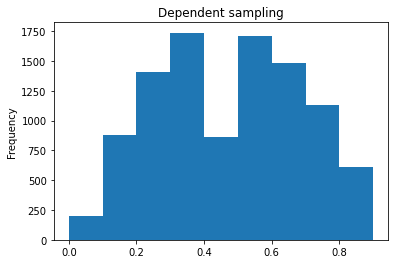

In [47]:
x[x['gene'].eq(0)]['dep_med'].plot.hist(bins=np.arange(0,1,0.1))
plt.title('Dependent sampling')
plt.show()
plt.close()

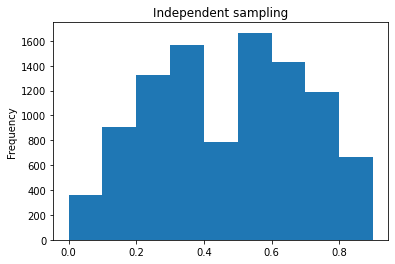

In [46]:
x[x['gene'].eq(0)]['indep_med'].plot.hist(bins=np.arange(0,1,0.1))
plt.title('Independent sampling')
plt.show()
plt.close()

In [28]:
p

0.565126465520061

In [4]:
def permute_median_over_cells_per_iteration(df, its=1000):
    """
    Lets say there are C cells and P permutations
    In this case there is a null distribution with P data points
    each data point is the median of the C cells periphery score
    then we have just a single null distribution for each gene, and a single "real median periphery score"
    """
    
    
    df['min_boundary_dist']
    

def permute(df, its=1000):
    """
    Basically just calls the per_cell_permute function
    """
    ret_df = pd.DataFrame()
    for cell_id,g in df.groupby('cell_id'):
        sub_df = per_cell_permute(g)
        sub_df['cell_id'] = cell_id
        ret_df = pd.concat((ret_df,sub_df))
        
    return ret_df


def per_cell_permute(df, its=1000):
    """
    """
    num_spots,_ = df.shape
    
    df['observed_normalized_rank'] = df['min_boundary_dist'].apply(
        lambda v: (v > df['min_boundary_dist']).sum()/len(df['min_boundary_dist'])
    )
    
    gene_df = df.groupby('target_molecule_name')[['observed_normalized_rank']].median()
    gene_df['num_spots'] = df.groupby('target_molecule_name').size()
    
    norm_ranks = np.vstack([
        np.random.permutation(np.arange(num_spots))/num_spots
        for i in range(its)
    ])
    
    per_spot_its_norm_ranks = pd.DataFrame(norm_ranks, columns=df['target_molecule_name'])
    per_gene_its_norm_ranks = per_spot_its_norm_ranks.T.groupby(per_spot_its_norm_ranks.columns).median()
            
    gene_df['fraction_perms_larger_than_obs'] = (
        per_gene_its_norm_ranks.sub(
            gene_df['observed_normalized_rank'], axis=0)
        .gt(0)
        .sum(axis=1)/its
    )
    
    gene_df['permuted_Q05'] = per_gene_its_norm_ranks.quantile(0.05, axis=1)
    gene_df['permuted_Q25'] = per_gene_its_norm_ranks.quantile(0.25, axis=1)
    gene_df['permuted_Q50'] = per_gene_its_norm_ranks.quantile(0.50, axis=1)
    gene_df['permuted_Q75'] = per_gene_its_norm_ranks.quantile(0.75, axis=1)
    gene_df['permuted_Q95'] = per_gene_its_norm_ranks.quantile(0.95, axis=1)
    
    return gene_df


start = time.time()
gene_df = permute(sub_df,10000)
print(time.time()-start)
gene_df

96.97475028038025


,observed_normalized_rank,num_spots,fraction_perms_larger_than_obs,permuted_Q05,permuted_Q25,permuted_Q50,permuted_Q75,permuted_Q95,cell_id
target_molecule_name,,,,,,,,,
Aqp4,0.400000,1,0.381,0.000000,0.200000,0.400000,0.600000,0.800000,100090343106976195519442675577848083308
Cxcl14,0.200000,1,0.610,0.000000,0.200000,0.400000,0.600000,0.800000,100090343106976195519442675577848083308
Pou3f3,0.800000,1,0.000,0.000000,0.200000,0.400000,0.600000,0.800000,100090343106976195519442675577848083308
Spon1,0.000000,1,0.801,0.000000,0.200000,0.400000,0.600000,0.800000,100090343106976195519442675577848083308
St6galnac5,0.600000,1,0.217,0.000000,0.200000,0.400000,0.600000,0.800000,100090343106976195519442675577848083308
...,...,...,...,...,...,...,...,...,...
Unc5d,0.621849,10,0.207,0.286224,0.401861,0.507203,0.604442,0.732953,98798783467407710419408042769213887522
Ust,0.831333,4,0.029,0.184214,0.367947,0.505402,0.637005,0.798950,98798783467407710419408042769213887522
Wipf3,0.228091,16,0.995,0.327071,0.429172,0.504802,0.578331,0.676561,98798783467407710419408042769213887522


In [371]:
df[df['target_molecule_name'].eq('Ctss')].groupby('cell_id')['min_boundary_dist'].rank()

,global_x,global_y,global_z,target_molecule_name,num_assigned_cells,cell_id,sample,min_boundary_dist
10241983,2087.2220,2315.5430,0.0,1700022I11Rik,1,21014129563353280159906900457364829387,mouse2sample2,2.044047
10241984,2056.8490,2233.5170,0.0,1810046K07Rik,1,202633430165103308157026102881717708611,mouse2sample2,0.415541
10241985,2125.1885,2297.5370,0.0,5730522E02Rik,1,86757150824204961994761474847558941717,mouse2sample2,1.545206
10241990,2096.8440,2322.7480,0.0,Acta2,1,198259986845326386185083518576166673028,mouse2sample2,2.683296
10241991,2090.9900,2329.2734,0.0,Acta2,1,198259986845326386185083518576166673028,mouse2sample2,0.066276


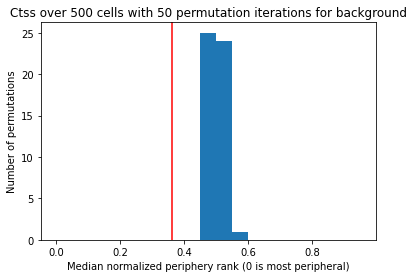

In [376]:
ret_df.loc['Ctss'].plot.hist(bins=np.arange(0,1,0.05))
plt.axvline(0.363,color='red')
plt.title('Ctss over 500 cells with 50 permutation iterations for background')
plt.xlabel('Median normalized periphery rank (0 is most peripheral)')
plt.ylabel('Number of permutations')
plt.show()
plt.close()

In [9]:
np.median(np.array([1, 1, 1, 0, 8, 9, 4, 8]))#, 0, 5,7]))

2.5

In [2]:
np.random.randint(0,10,10)

array([1, 1, 1, 0, 8, 9, 4, 8, 0, 5])

In [3]:
spots = pd.read_csv('../processed_data/q90_rna_spots.csv')
cells = pd.read_csv('../processed_data/q90_cells.csv')

In [278]:
df.head()

,global_x,global_y,global_z,target_molecule_name,num_assigned_cells,cell_id,sample,min_boundary_dist
0,-4237.7397,1681.8490,0.0,Acta2,1,217951229059897556843731256135790480948,mouse1sample2,4.981020
1,-4183.0010,1688.5905,0.0,Acta2,1,281878279612082858224382179441472205807,mouse1sample2,1.891179
2,-4215.4233,1699.2443,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,1.670875
3,-4207.3945,1706.8620,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,5.015634
4,-4206.7200,1711.7010,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,0.636409


In [279]:
df = sub_df.copy()

In [281]:
df.groupby('target_molecule_name').size()

target_molecule_name
1700022I11Rik       27
1810046K07Rik      152
5031425F14Rik       46
5730522E02Rik      112
Acta2              522
                 ...  
Vtn                399
Vwc2               362
Wipf3            30126
Wnt7b             3872
Zfp804b            428
Length: 252, dtype: int64

In [ ]:
df.pivot_table()

In [286]:
cell_gene_counts = (
    df.groupby(['target_molecule_name','cell_id'])
    .size()
    .reset_index()
    .pivot_table(
        index = 'target_molecule_name',
        columns = 'cell_id',
        values = 0,
    )
)

cell_gene_counts

cell_id,100119564138240934343675231555416026680,101296445222556202116044850911842446952,101814745547163407788608267209688772234,101834332862690515873103260287037194478,102274215114444445359383535507974597226,102550986445790597956352131295110346114,102860516868483546320249896140208642792,104231046656146275436898522376419674157,104378554986971873351370319264431708799,104444247350332857217763623104191131368,...,94599939628976565882952659075127841734,95529686896953901991672753520608026107,9560966470901538259273991914871260341,96313750575909405087424137325288832120,96771105158314764059027967259449011344,97264673034915410979949399653525492604,97699946244916966158833629867404216600,98373837971534571493484421609973214664,98459407585642856854333219763389689067,9846181674415319094249711305090477950
target_molecule_name,,,,,,,,,,,,,,,,,,,,,
1700022I11Rik,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1810046K07Rik,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5031425F14Rik,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5730522E02Rik,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Acta2,1.0,NaN,NaN,2.0,1.0,2.0,NaN,NaN,1.0,NaN,...,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vtn,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,2.0,...,NaN,32.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN
Vwc2,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,8.0,NaN,...,NaN,18.0,NaN,NaN,NaN,7.0,NaN,NaN,1.0,NaN
Wipf3,4.0,52.0,7.0,90.0,119.0,45.0,79.0,77.0,11.0,72.0,...,9.0,2.0,87.0,93.0,5.0,23.0,8.0,80.0,77.0,68.0


In [304]:
np.median(vs[735:737])

249.5

In [306]:
ends

target_molecule_name
1810046K07Rik      1.0
Acta2              2.0
Adra1b            18.0
Aqp4              23.0
Bcl11b            25.0
                 ...  
Unc5d            704.0
Vwc2             705.0
Wipf3            709.0
Wnt7b            735.0
Zfp804b          737.0
Name: 100119564138240934343675231555416026680, Length: 91, dtype: float64

In [325]:
type(ends)

pandas.core.series.Series

In [335]:
ends.astype(int)

array([  1,   2,  18,  23,  25,  38,  42,  48,  92,  93, 104, 106, 110,
       120, 121, 124, 139, 142, 169, 198, 199, 200, 201, 203, 206, 209,
       221, 233, 234, 238, 249, 253, 260, 264, 265, 282, 283, 284, 289,
       292, 295, 297, 300, 323, 325, 326, 327, 357, 361, 362, 363, 364,
       367, 376, 389, 394, 395, 396, 414, 421, 436, 439, 440, 443, 445,
       474, 476, 506, 513, 514, 526, 574, 575, 589, 645, 658, 659, 667,
       671, 675, 677, 689, 692, 697, 699, 700, 704, 705, 709, 735, 737])

In [353]:
cell_gene_mask

cell_id,100119564138240934343675231555416026680,101296445222556202116044850911842446952,101814745547163407788608267209688772234,101834332862690515873103260287037194478,102274215114444445359383535507974597226,102550986445790597956352131295110346114,102860516868483546320249896140208642792,104231046656146275436898522376419674157,104378554986971873351370319264431708799,104444247350332857217763623104191131368,...,94599939628976565882952659075127841734,95529686896953901991672753520608026107,9560966470901538259273991914871260341,96313750575909405087424137325288832120,96771105158314764059027967259449011344,97264673034915410979949399653525492604,97699946244916966158833629867404216600,98373837971534571493484421609973214664,98459407585642856854333219763389689067,9846181674415319094249711305090477950
target_molecule_name,,,,,,,,,,,,,,,,,,,,,
1700022I11Rik,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1810046K07Rik,True,False,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
5031425F14Rik,False,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
5730522E02Rik,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
Acta2,True,False,False,True,True,True,False,False,True,False,...,True,True,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vtn,False,False,True,False,False,False,True,False,False,True,...,False,True,True,False,False,True,False,True,False,False
Vwc2,True,False,False,False,False,False,True,False,True,False,...,False,True,False,False,False,True,False,False,True,False
Wipf3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [361]:
###################################################################################
#   This is the second method where I'm doing median over cells per permutation   #
#   its too slow for now, only able to do 50 permutations. not vectorized         #
###################################################################################
num_permutations = 50

ret_df = pd.DataFrame()

cell_gene_counts = (
    df.groupby(['target_molecule_name','cell_id'])
    .size()
    .reset_index()
    .pivot_table(
        index = 'target_molecule_name',
        columns = 'cell_id',
        values = 0,
    )
)

for permutation_i in range(num_permutations):
    print(permutation_i)
    cell_gene_mask = cell_gene_counts.copy()

    for cell_id in cell_gene_counts.columns:
        num_spots = cell_gene_counts[cell_id].sum()
        vs = np.random.permutation(np.arange(num_spots))/num_spots

        ends = np.cumsum(cell_gene_counts[cell_id].dropna().values).astype(int)
        starts = np.insert(ends[:-1],0,0,axis=0)

        medians = [np.median(vs[s:e]) for s,e in zip(starts,ends)]

        cell_gene_mask.loc[cell_gene_mask[cell_id].notnull(), cell_id] = medians

    ret_df = pd.concat((ret_df,cell_gene_mask.median(axis=1)),axis=1)

ret_df.columns = np.arange(num_permutations)
ret_df.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
target_molecule_name,,,,,,,,,,,,,,,,,,,,,
1700022I11Rik,0.476963,0.563060,0.438471,0.465625,0.396541,0.519739,0.624889,0.650085,0.559058,0.426118,...,0.222830,0.494241,0.393450,0.465941,0.671798,0.540139,0.522154,0.407263,0.594068,0.439734
1810046K07Rik,0.557471,0.536919,0.490106,0.496676,0.539623,0.521302,0.528949,0.490870,0.492298,0.454545,...,0.546272,0.497006,0.496471,0.537647,0.442598,0.572093,0.523810,0.554825,0.497006,0.550245
5031425F14Rik,0.530259,0.474965,0.507658,0.517258,0.500138,0.601214,0.499769,0.497742,0.380977,0.409133,...,0.565416,0.499954,0.455997,0.383524,0.435927,0.489850,0.380846,0.532021,0.408418,0.497737
5730522E02Rik,0.443169,0.543645,0.468254,0.491325,0.434866,0.505060,0.466270,0.480186,0.495486,0.525278,...,0.520758,0.564516,0.512088,0.560471,0.559910,0.533333,0.498901,0.583525,0.497492,0.471871
Acta2,0.486604,0.517803,0.566929,0.528037,0.476387,0.498866,0.508186,0.530120,0.502787,0.512133,...,0.498375,0.488575,0.483751,0.455044,0.483548,0.460897,0.510454,0.491743,0.451807,0.476148


In [362]:
ret_df.to_csv('../processed_data/20210125_500cells_permuted_periph_median_cell_per_pemute.csv')

In [ ]:
print('hello')

In [ ]:
ret_df.loc['Ctss']

In [280]:
df.groupby('cell_id')['']

(498227, 8)

In [10]:
sub_df

NameError: name 'sub_df' is not defined

In [12]:
df.head()

,global_x,global_y,global_z,target_molecule_name,num_assigned_cells,cell_id,sample,min_boundary_dist
0,-4237.7397,1681.8490,0.0,Acta2,1,217951229059897556843731256135790480948,mouse1sample2,4.981020
1,-4183.0010,1688.5905,0.0,Acta2,1,281878279612082858224382179441472205807,mouse1sample2,1.891179
2,-4215.4233,1699.2443,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,1.670875
3,-4207.3945,1706.8620,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,5.015634
4,-4206.7200,1711.7010,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2,0.636409


In [13]:
df['cell_id'].unique().size

237879

In [14]:
sub_df = df[df['cell_id'].isin(df.drop_duplicates('cell_id').head(100)['cell_id'].values)]

In [256]:
gene_df.to_csv('../processed_data/20210125_500cells_permuted_periph.csv')

In [231]:
gene_df.sort_values(['fraction_perms_smaller_than_obs'],ascending=False)

,observed_normalized_rank,num_spots,fraction_perms_smaller_than_obs,permuted_Q05,permuted_Q25,permuted_Q50,permuted_Q75,permuted_Q95
target_molecule_name,,,,,,,,
Pcdh8,0.253981,29,0.9984,0.355096,0.437898,0.500796,0.562898,0.647293
Pdlim5,0.003981,1,0.9948,0.050159,0.249204,0.500000,0.753981,0.951433
Ust,0.008758,1,0.9899,0.053344,0.249204,0.497611,0.743631,0.946656
Blank-9,0.017516,1,0.9839,0.050955,0.251592,0.505175,0.751592,0.949045
Sertm1,0.360669,47,0.9765,0.382962,0.451433,0.499204,0.548567,0.614650
...,...,...,...,...,...,...,...,...
Rgs6,0.839968,9,0.0070,0.252389,0.390127,0.498408,0.606091,0.747611
Egfem1,0.847930,8,0.0057,0.260729,0.395701,0.500398,0.605096,0.743232
Sulf1,0.960191,2,0.0032,0.159216,0.354697,0.500000,0.646099,0.837978


In [9]:
def permute_gene_labels_and_recalc_periph_score(df, its=10):
    """
    Right now function assumes that all spots are part of the same cell
    """
    gene_dist_df = sub_df[['target_molecule_name','min_boundary_dist']].copy()

    nrows,ncols = gene_dist_df.shape
    genes = gene_dist_df['target_molecule_name'].unique()
    inds = np.arange(nrows)

    ret_df = pd.DataFrame(index=genes)
    
    gene_dist_df['normalized_rank'] = gene_dist_df['min_boundary_dist'].rank() / nrows
    vs = gene_dist_df.groupby('target_molecule_name')['normalized_rank'].median()
    ret_df['unpermuted'] = vs

    for i in range(its):
        np.random.shuffle(inds)

        gene_dist_df['reordered_dists'] = list(gene_dist_df.iloc[inds]['min_boundary_dist'])
        gene_dist_df['normalized_rank'] = gene_dist_df['reordered_dists'].rank() / nrows
        vs = gene_dist_df.groupby('target_molecule_name')['normalized_rank'].median()
        ret_df['iteration_{}'.format(i)] = vs

    return ret_df.T

start = time.time()
x = permute_gene_labels_and_recalc_periph_score(sub_df,1000)
print(time.time()-start)
x

3.866495370864868


,Acta2,Bdnf,Bmpr1b,C1ql3,Camk2d,Ccdc3,Cdh13,Chn2,Cntnap5b,Cux2,...,Rgs5,Sncg,Sulf1,Tbc1d4,Th,Ust,Ceacam9,Grik1,Nhs,Vtn
unpermuted,0.326035,0.273089,0.546975,0.475318,0.417994,0.394904,0.460589,0.453025,0.607086,0.495621,...,0.056529,0.699841,0.960987,0.772293,0.901274,0.009554,0.757962,0.966561,0.351911,0.043790
iteration_0,0.535032,0.562102,0.614650,0.601911,0.511943,0.529857,0.509554,0.141720,0.526274,0.477707,...,0.655255,0.548567,0.599920,0.703822,0.753981,0.147293,0.127389,0.761943,0.193471,0.543790
iteration_1,0.322850,0.603503,0.591561,0.489650,0.442277,0.394506,0.533041,0.660032,0.456608,0.487261,...,0.820064,0.851911,0.819666,0.562102,0.795382,0.899682,0.137739,0.051752,0.659236,0.738854
iteration_2,0.513933,0.476115,0.410828,0.462580,0.410430,0.639331,0.410430,0.299363,0.515924,0.625796,...,0.891720,0.661624,0.605494,0.070860,0.893312,0.642516,0.262739,0.614650,0.727707,0.678344
iteration_3,0.580016,0.622611,0.387739,0.460987,0.500000,0.424363,0.511943,0.074045,0.302548,0.511146,...,0.391720,0.160032,0.581210,0.009554,0.870223,0.958599,0.349522,0.478503,0.316083,0.753981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iteration_995,0.495223,0.583599,0.333599,0.445064,0.455812,0.442675,0.555732,0.582803,0.286226,0.457404,...,0.398885,0.891720,0.706608,0.808121,0.081210,0.040605,0.187102,0.306529,0.369427,0.903662
iteration_996,0.576433,0.234076,0.603503,0.635350,0.504777,0.470143,0.572054,0.269904,0.411624,0.515924,...,0.091561,0.680732,0.687500,0.341561,0.187898,0.656847,0.591561,0.734873,0.538217,0.911624
iteration_997,0.297373,0.494427,0.456210,0.379777,0.489252,0.519506,0.500796,0.850318,0.664411,0.492834,...,0.672771,0.256369,0.759156,0.078025,0.616242,0.804140,0.492038,0.718153,0.171975,0.016720
iteration_998,0.174761,0.274682,0.830414,0.499204,0.513535,0.360669,0.531847,0.992038,0.457006,0.526274,...,0.864650,0.736465,0.950239,0.198248,0.842357,0.714172,0.571656,0.351911,0.101911,0.780255


In [10]:
sub_df.shape

(1256, 8)

In [14]:
spots.groupby('cell_id').size().median()

895.0

In [11]:
cells['cell_id'].unique().size

23751

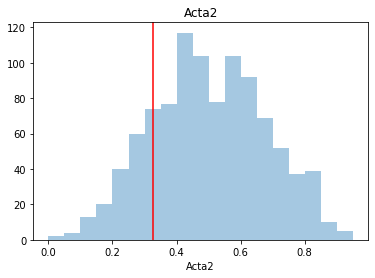

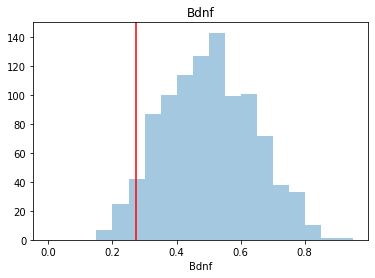

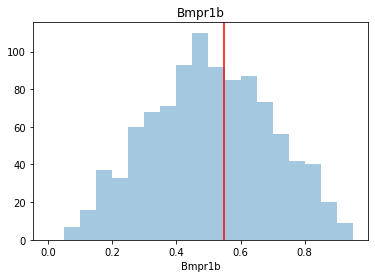

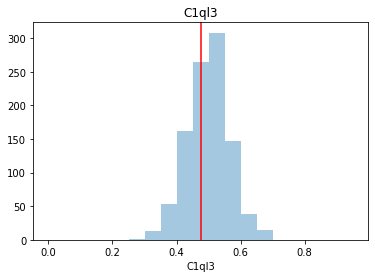

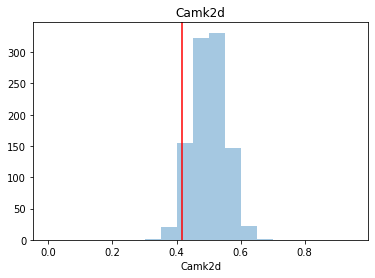

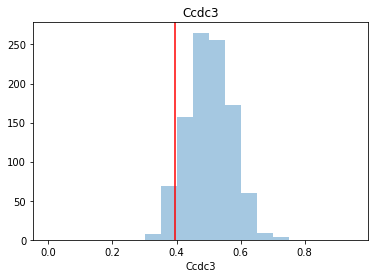

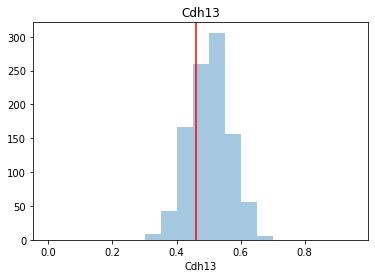

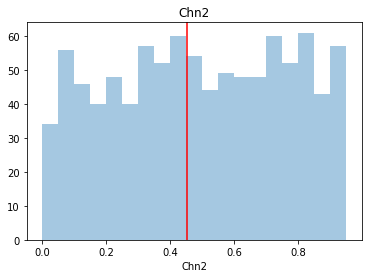

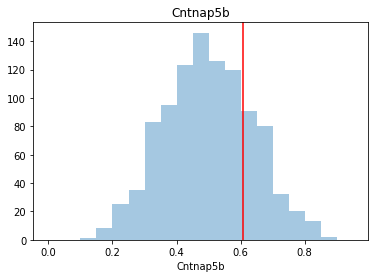

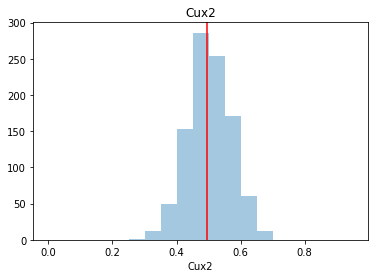

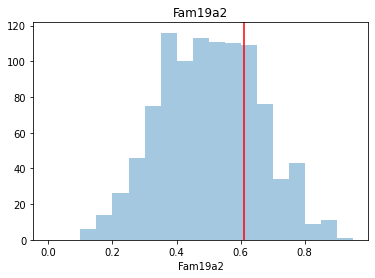

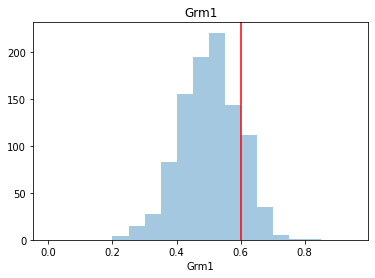

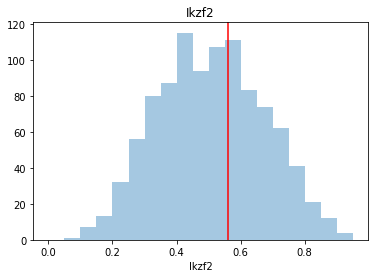

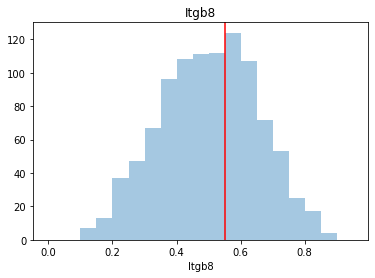

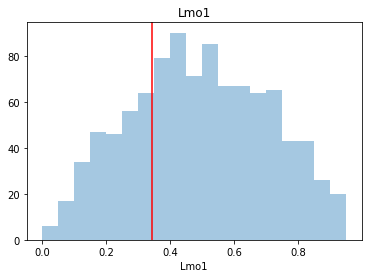

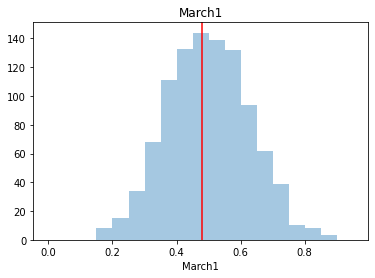

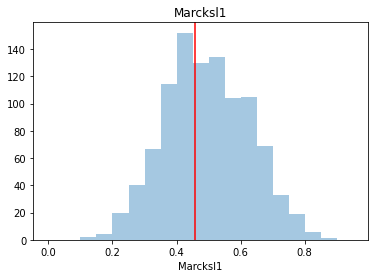

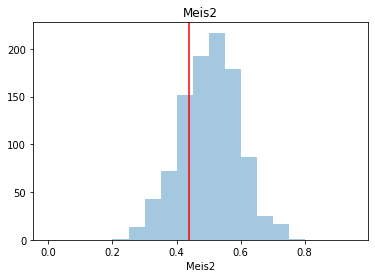

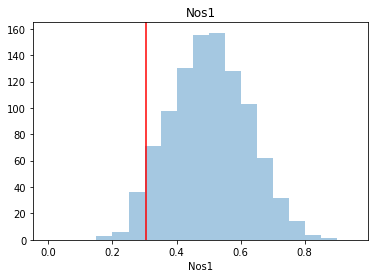

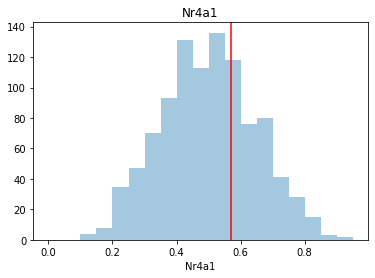

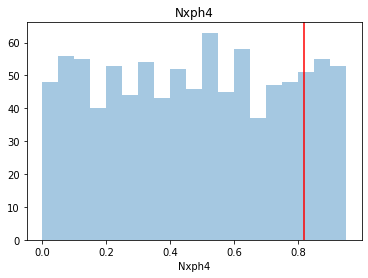

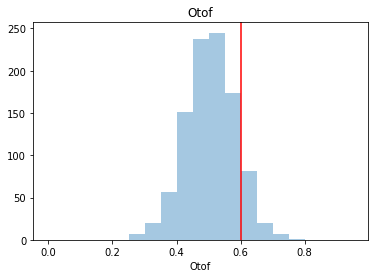

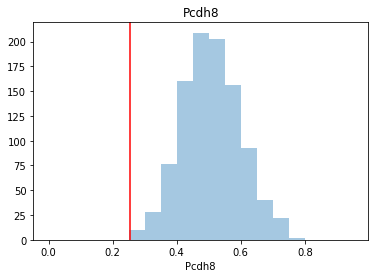

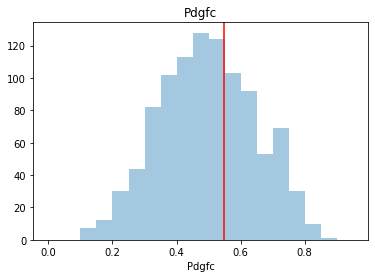

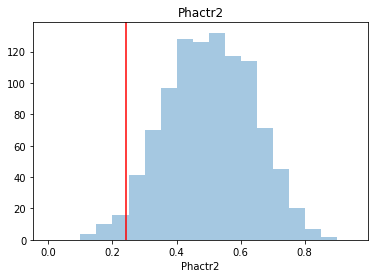

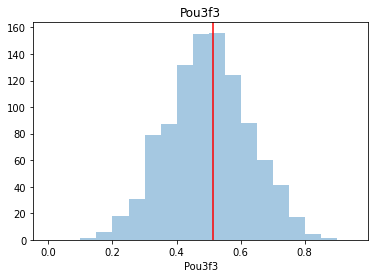

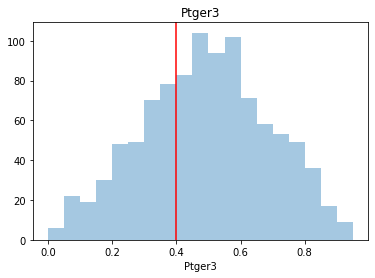

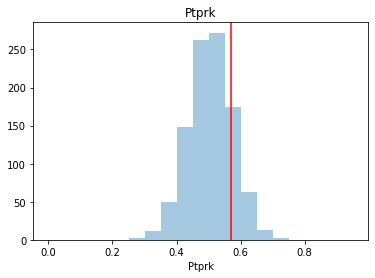

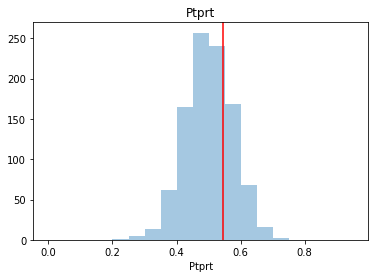

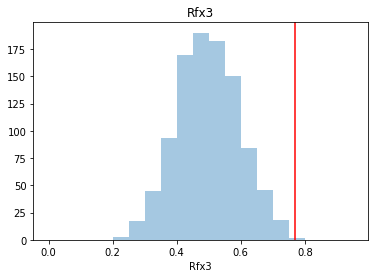

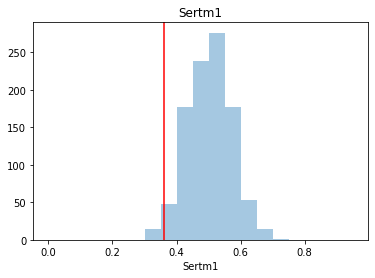

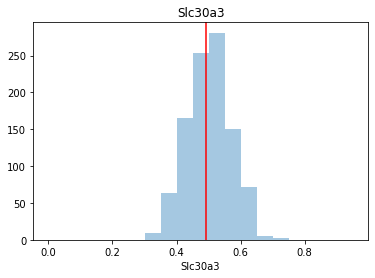

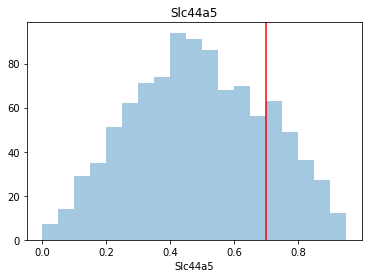

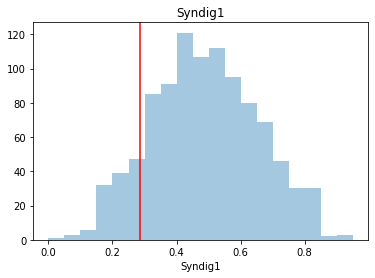

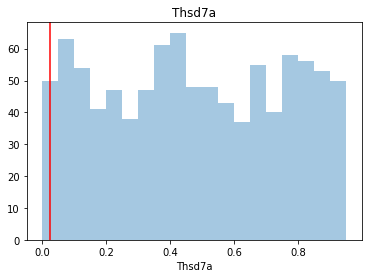

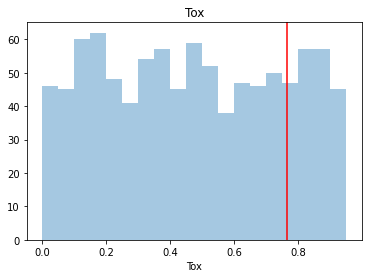

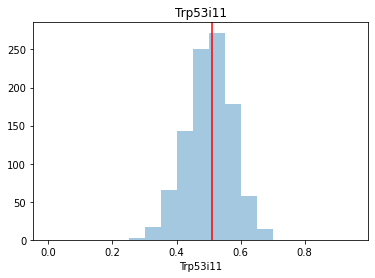

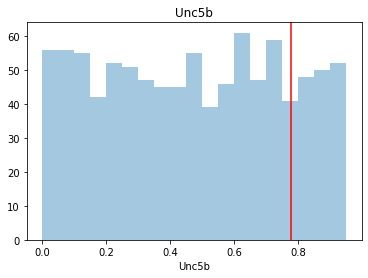

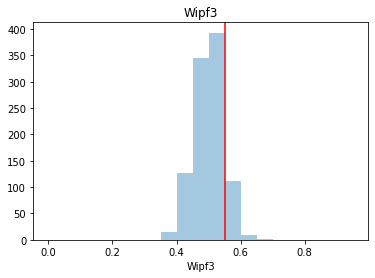

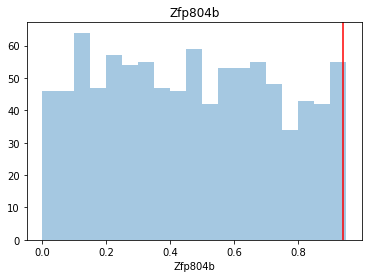

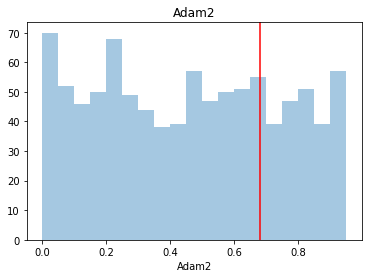

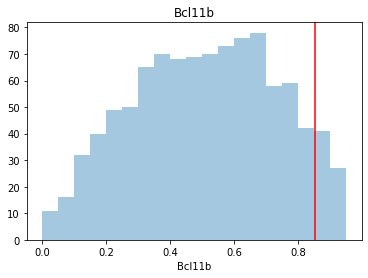

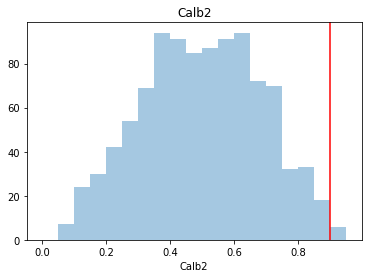

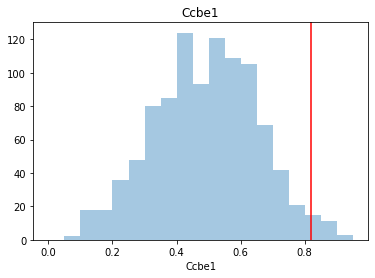

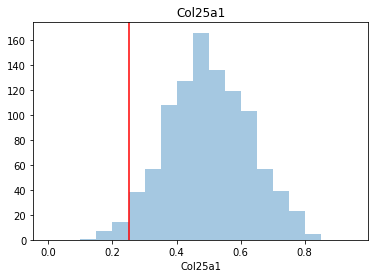

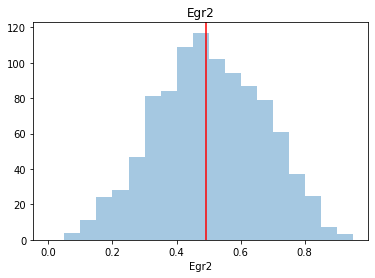

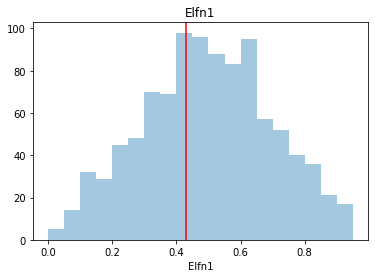

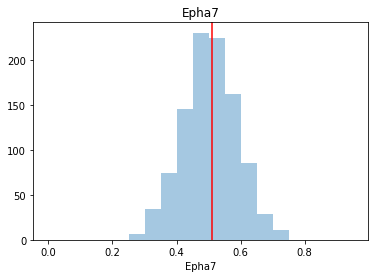

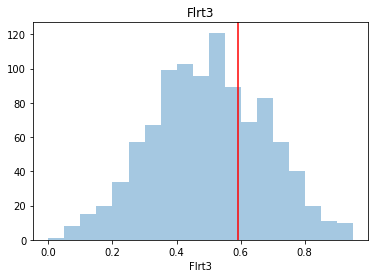

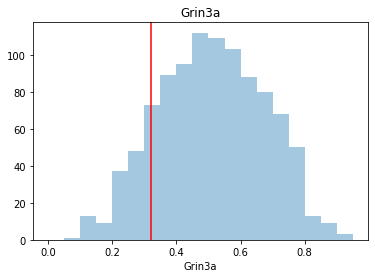

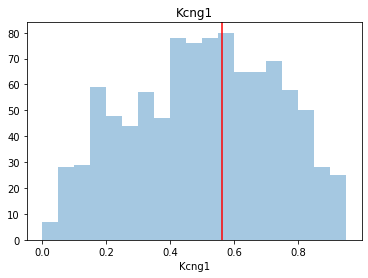

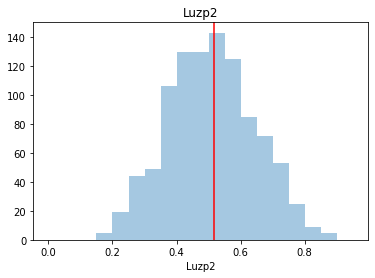

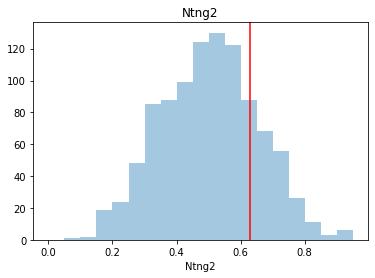

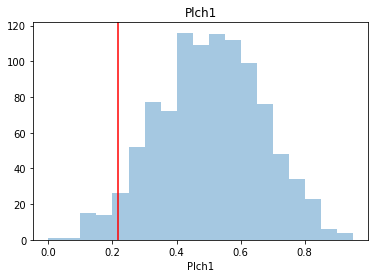

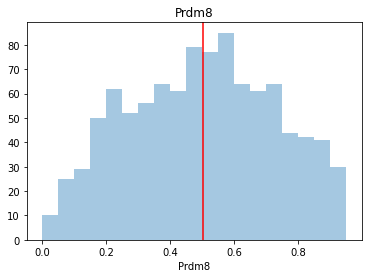

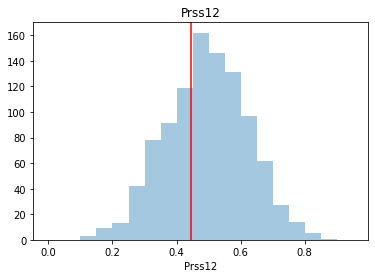

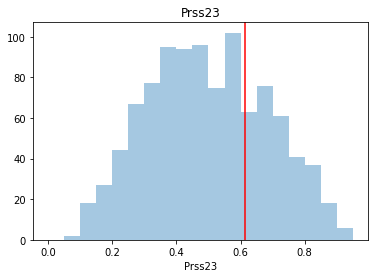

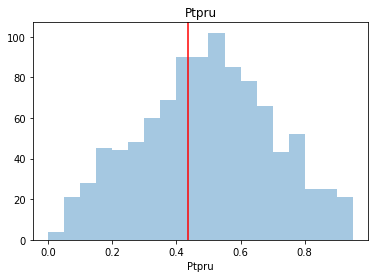

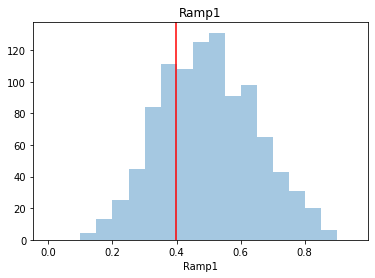

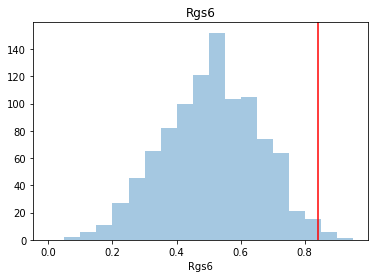

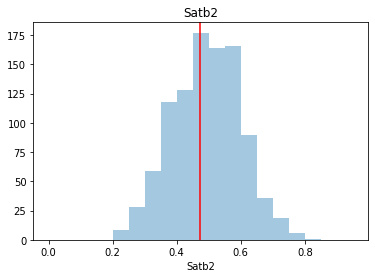

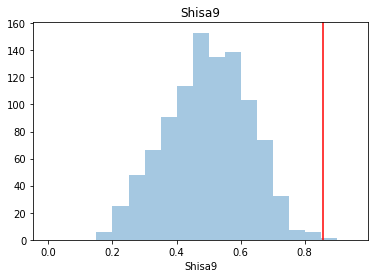

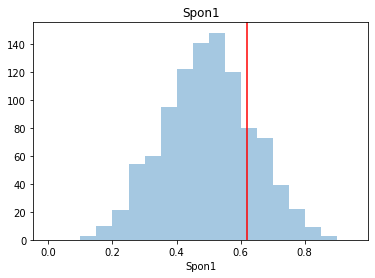

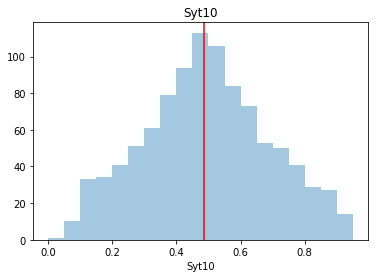

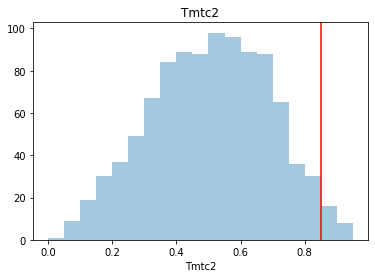

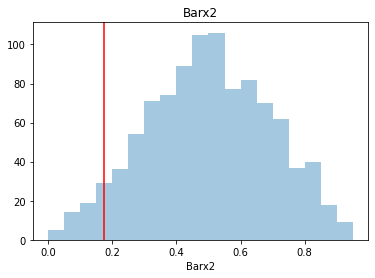

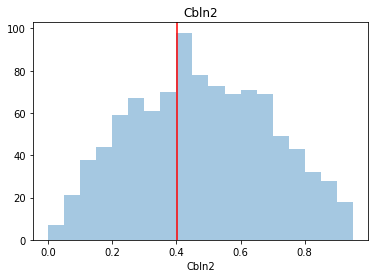

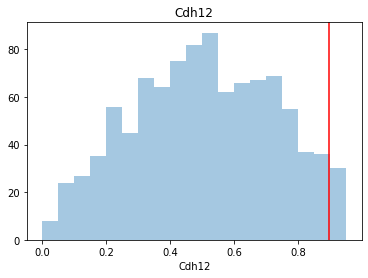

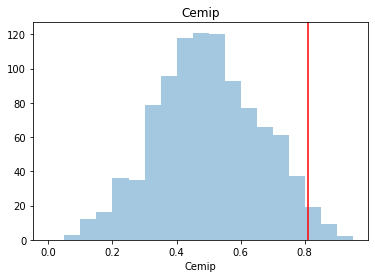

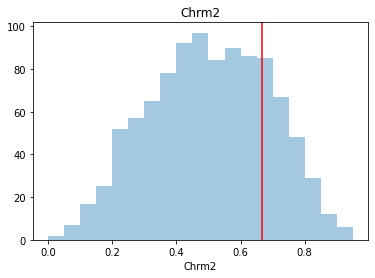

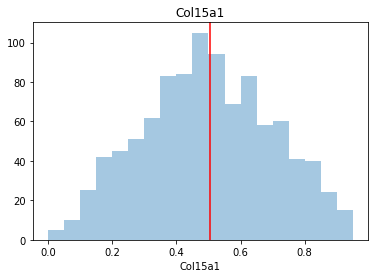

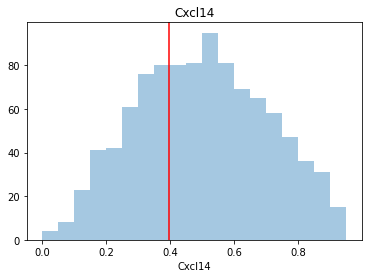

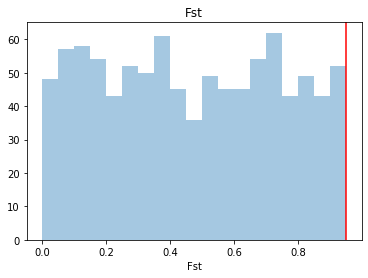

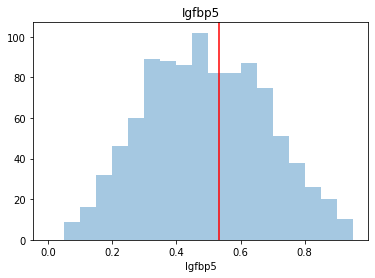

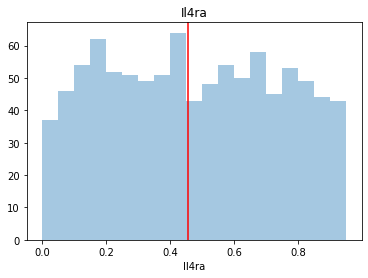

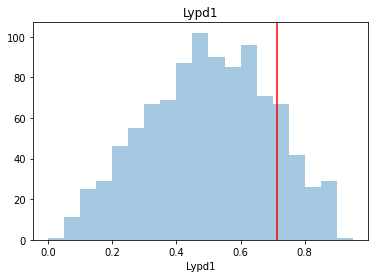

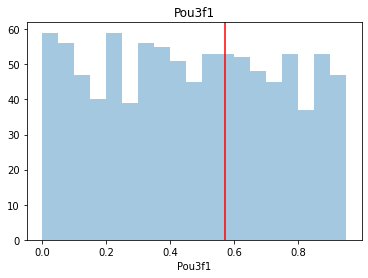

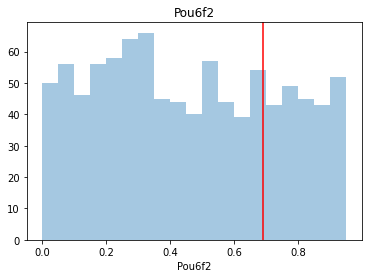

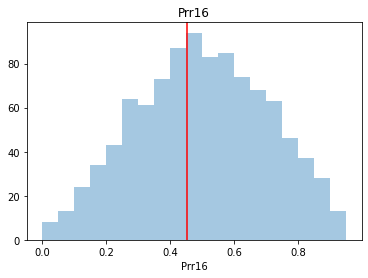

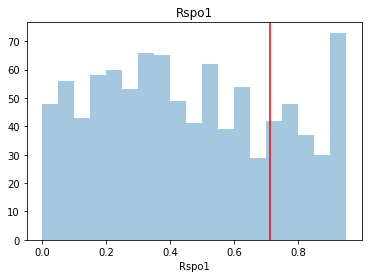

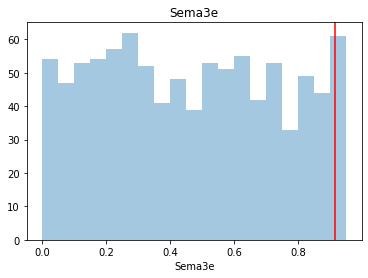

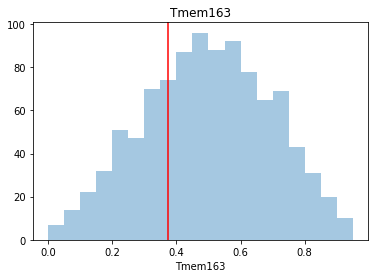

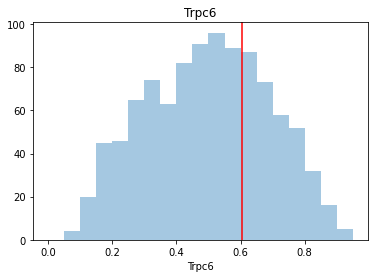

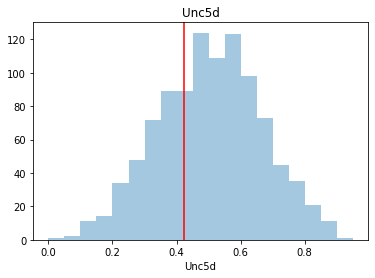

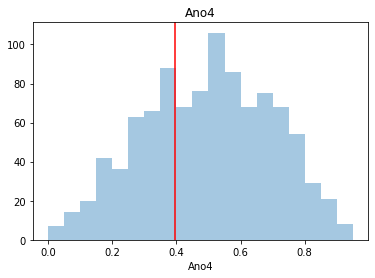

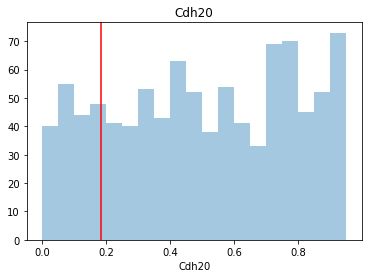

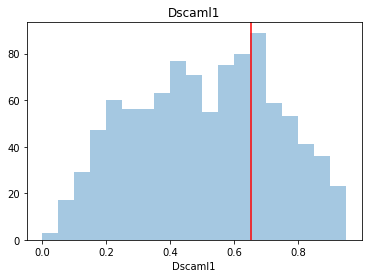

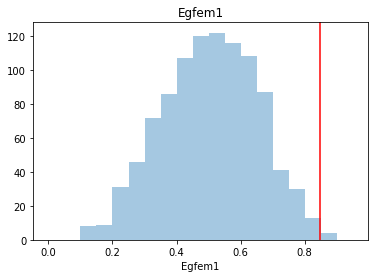

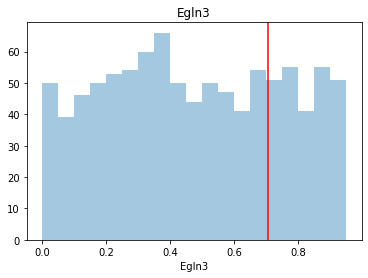

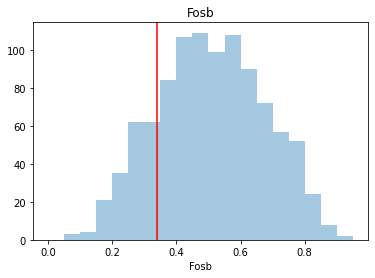

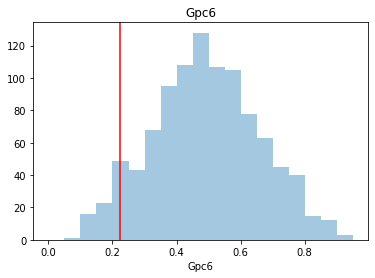

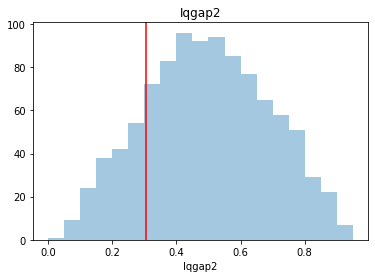

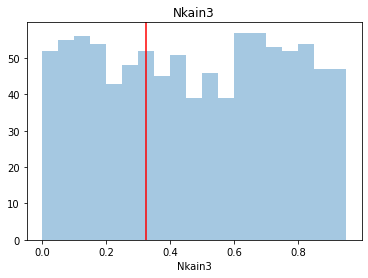

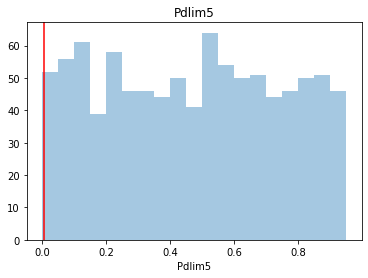

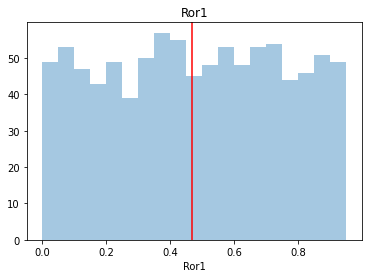

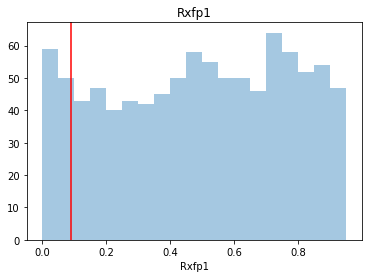

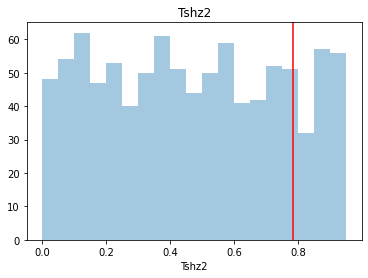

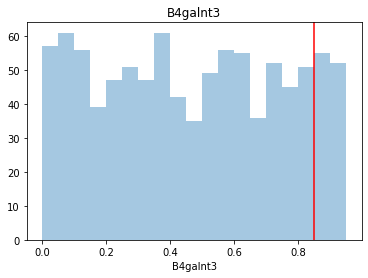

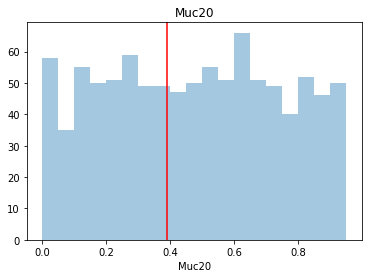

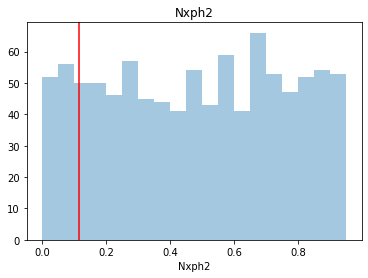

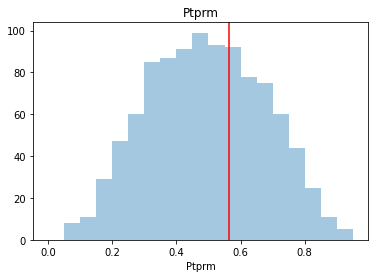

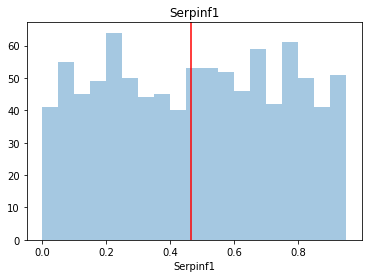

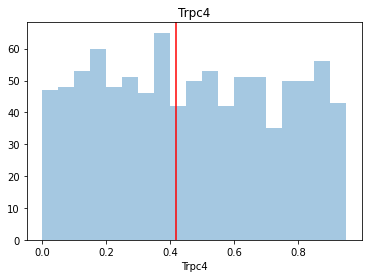

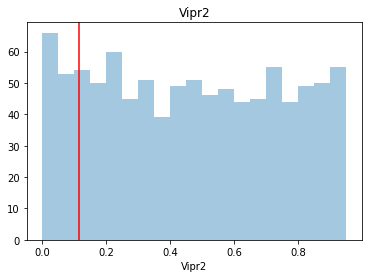

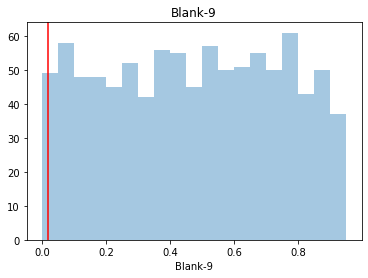

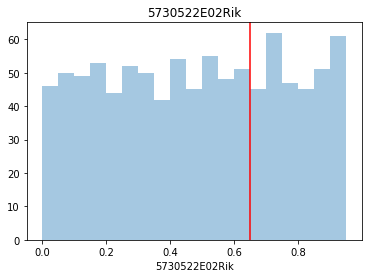

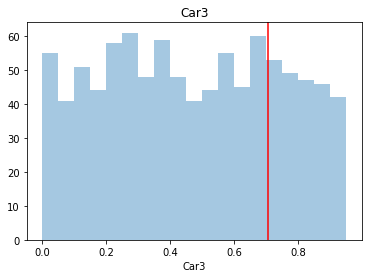

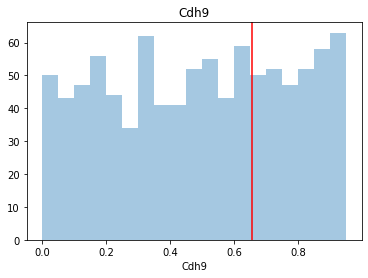

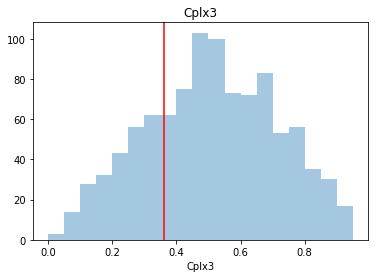

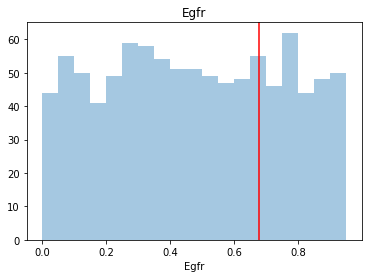

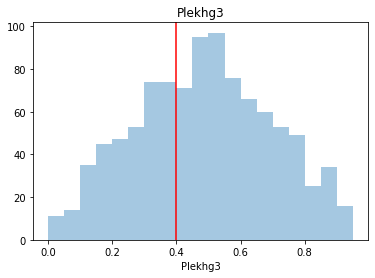

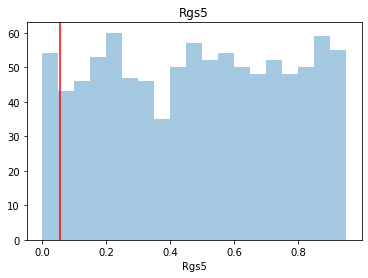

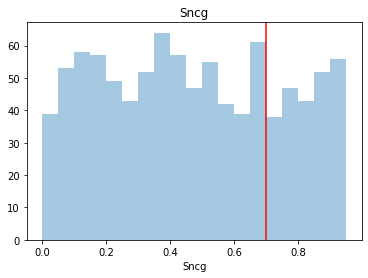

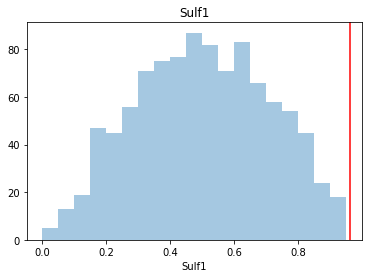

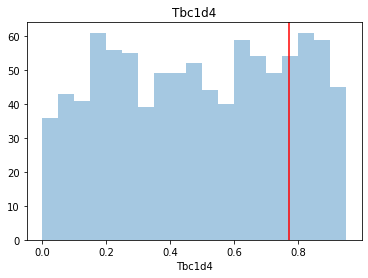

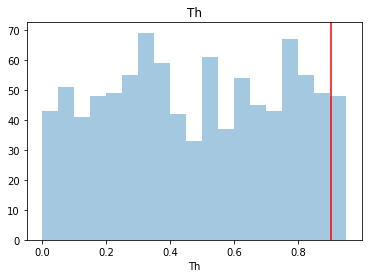

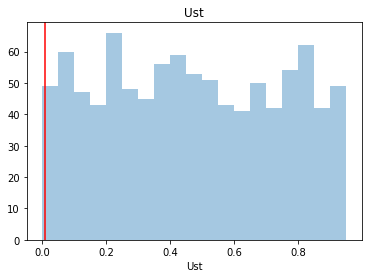

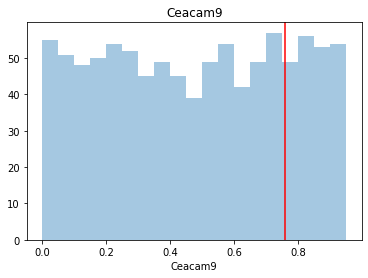

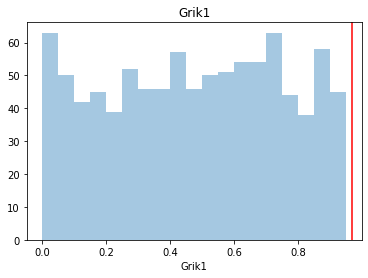

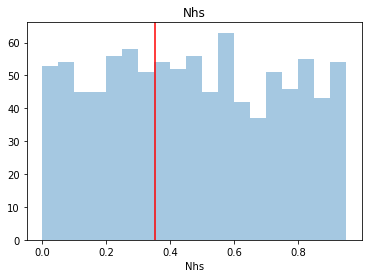

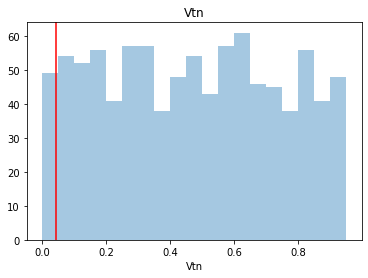

In [74]:
gene = 'Acta2'

for gene in x.columns:
    sns.distplot(
        x[gene].iloc[1:],
        kde=False,
        bins=np.arange(0,1,0.05)
    )
    plt.axvline(x[gene].iloc[0],color='red')
    plt.title(gene)
    plt.show()
    plt.close()

In [38]:
sub_df = df[df['cell_id'].eq('217951229059897556843731256135790480948')]
sub_df

,global_x,global_y,global_z,target_molecule_name,num_assigned_cells,cell_id,sample,min_boundary_dist
0,-4237.7397,1681.8490,0.0,Acta2,1,217951229059897556843731256135790480948,mouse1sample2,4.981020
43,-4239.4756,1680.8799,0.0,Bdnf,1,217951229059897556843731256135790480948,mouse1sample2,3.834335
45,-4241.7300,1679.4764,0.0,Bmpr1b,1,217951229059897556843731256135790480948,mouse1sample2,2.239659
51,-4241.6343,1675.6117,0.0,C1ql3,1,217951229059897556843731256135790480948,mouse1sample2,1.358859
52,-4237.3070,1679.8102,0.0,C1ql3,1,217951229059897556843731256135790480948,mouse1sample2,6.250636
...,...,...,...,...,...,...,...,...
21462,-4239.4976,1684.1333,9.0,Wipf3,1,217951229059897556843731256135790480948,mouse1sample2,2.247704
21464,-4237.2783,1685.1696,9.0,Wipf3,1,217951229059897556843731256135790480948,mouse1sample2,2.578861
21465,-4235.1040,1685.5491,9.0,Wipf3,1,217951229059897556843731256135790480948,mouse1sample2,2.509724
21466,-4236.4976,1686.3976,9.0,Wipf3,1,217951229059897556843731256135790480948,mouse1sample2,1.446619


# Proof of principle permutations

In [257]:
x = pd.read_csv('../processed_data/20210125_500cells_permuted_periph.csv')
x.head()

,target_molecule_name,observed_normalized_rank,num_spots,fraction_perms_larger_than_obs,permuted_Q05,permuted_Q25,permuted_Q50,permuted_Q75,permuted_Q95,cell_id
0,1810046K07Rik,0.982361,1,0.013,0.047490,0.227612,0.487788,0.720149,0.947151,100119564138240934343675231555416026680
1,Acta2,0.845319,1,0.151,0.051560,0.246947,0.500000,0.747626,0.937585,100119564138240934343675231555416026680
2,Adra1b,0.454545,16,0.654,0.323541,0.422829,0.502035,0.584125,0.687246,100119564138240934343675231555416026680
3,Aqp4,0.139756,5,0.981,0.200746,0.359227,0.503392,0.644505,0.815468,100119564138240934343675231555416026680
4,Bcl11b,0.818182,2,0.064,0.143114,0.342436,0.476255,0.639417,0.834464,100119564138240934343675231555416026680


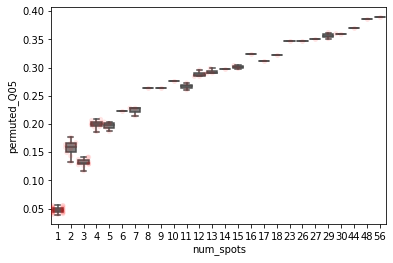

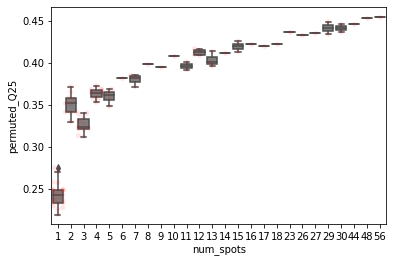

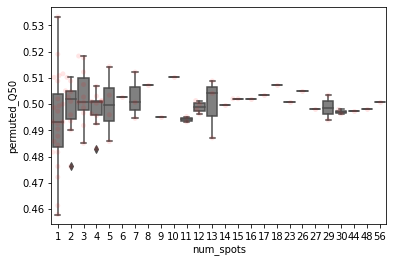

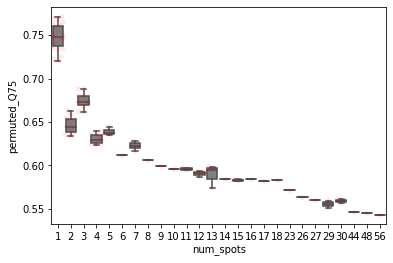

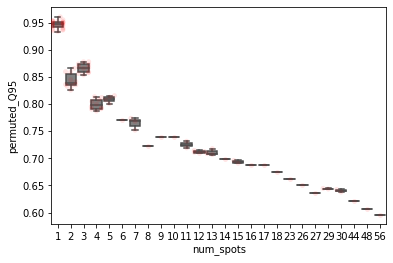

In [258]:
for cell_id,g in x.groupby('cell_id'):
    for c in [c for c in g.columns if 'Q' in c]:
        sns.boxplot(
            x = 'num_spots',
            y = c,
            color = 'grey',
            data = g,
        )
        sns.swarmplot(
            x = 'num_spots',
            y = c,
            color = 'red',
            alpha = 0.1,
            data = g,
        )
        plt.show()
        plt.close()
    break

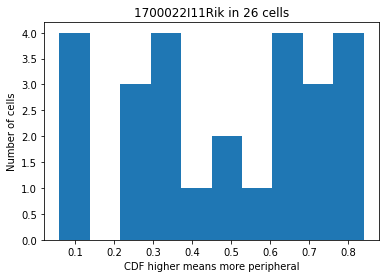

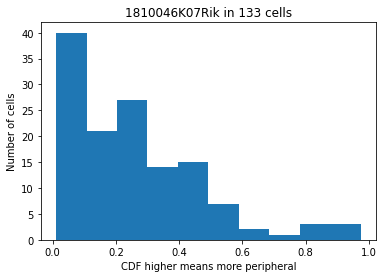

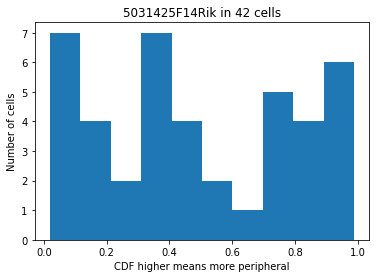

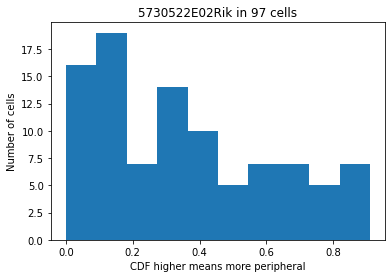

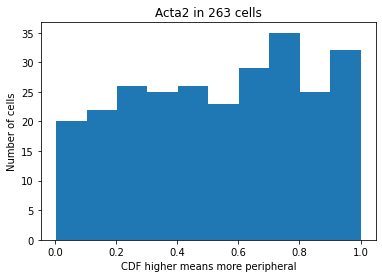

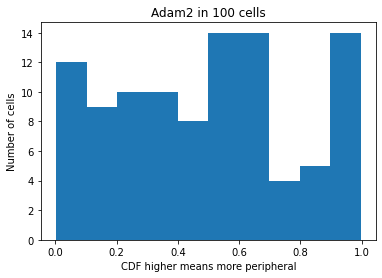

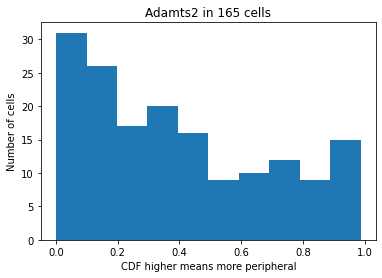

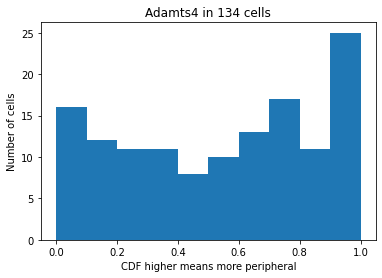

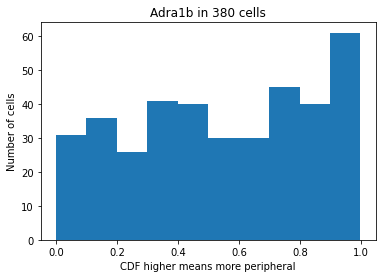

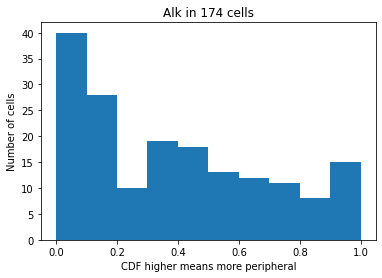

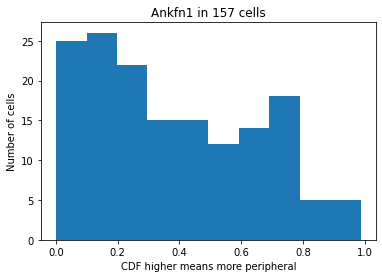

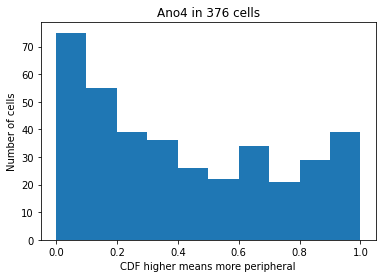

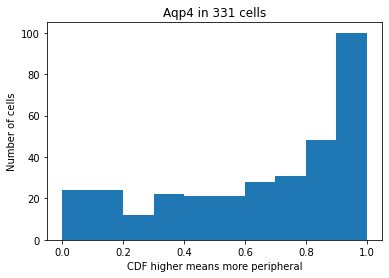

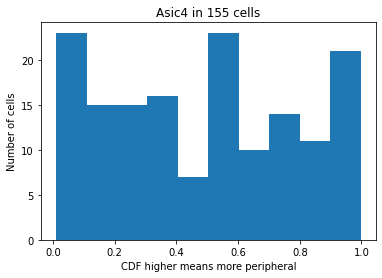

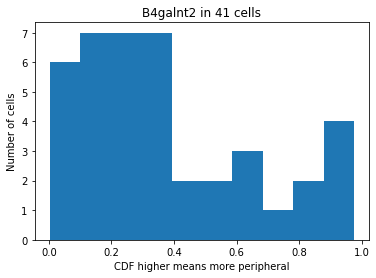

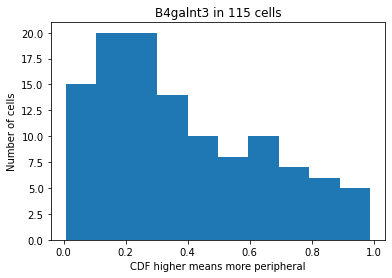

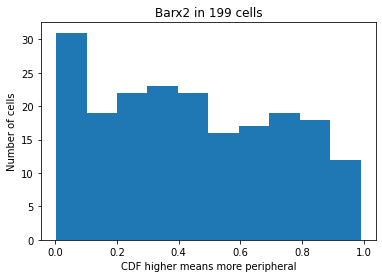

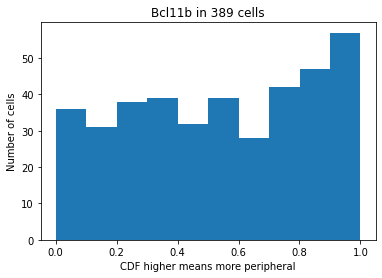

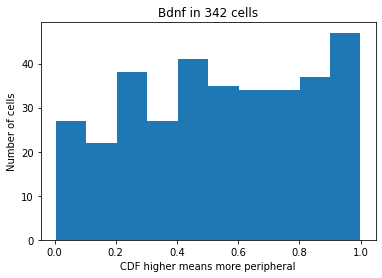

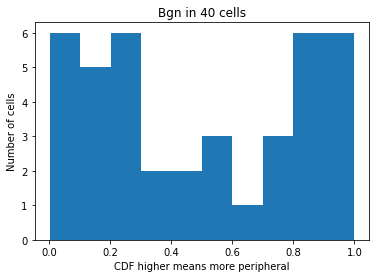

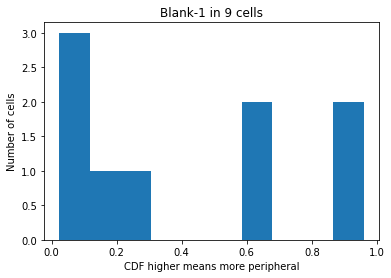

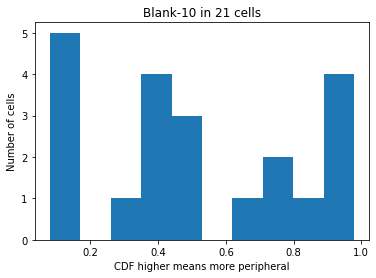

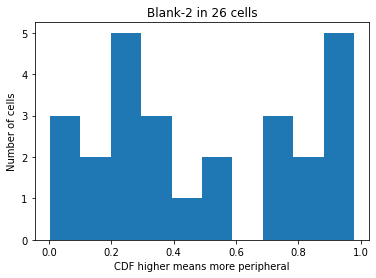

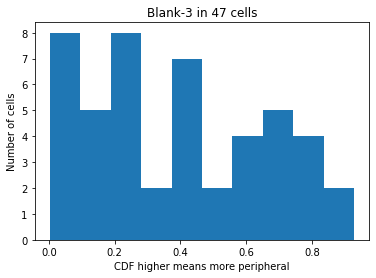

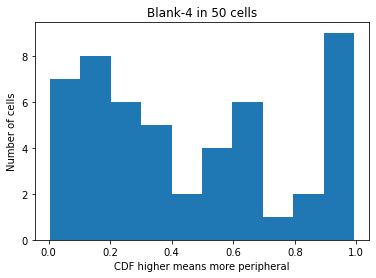

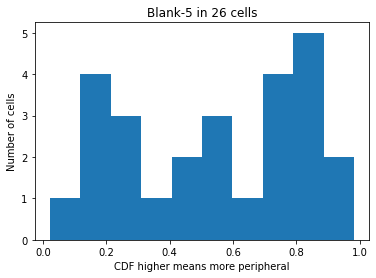

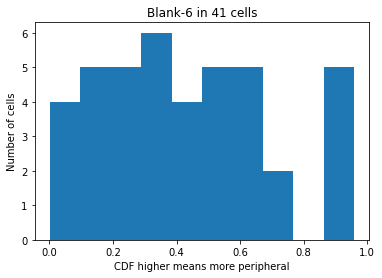

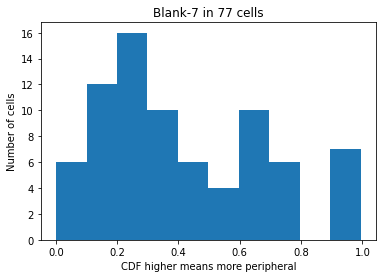

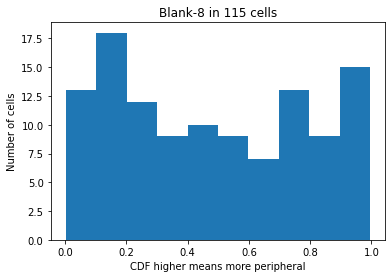

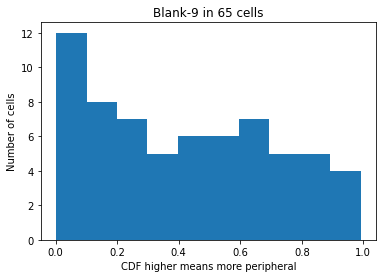

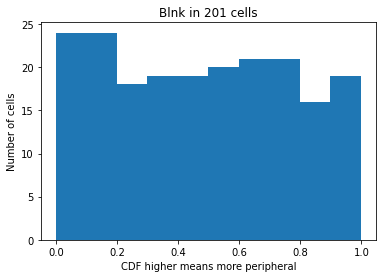

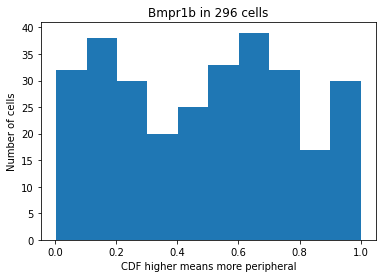

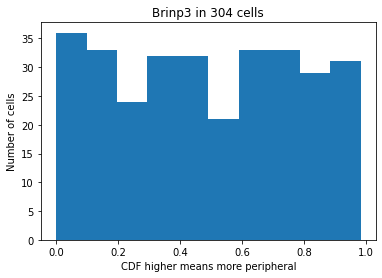

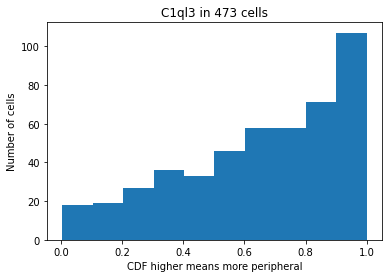

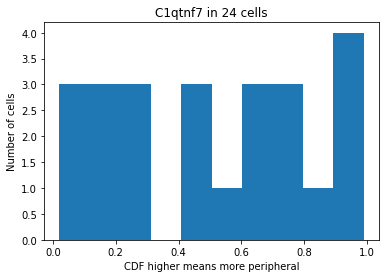

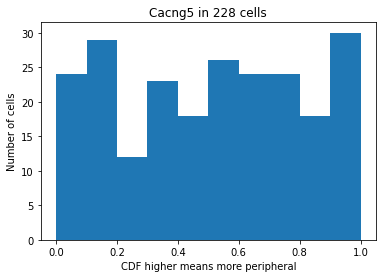

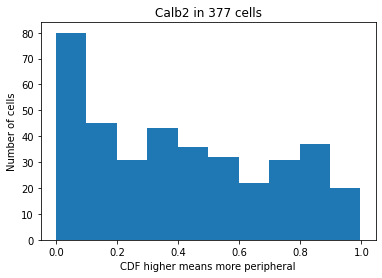

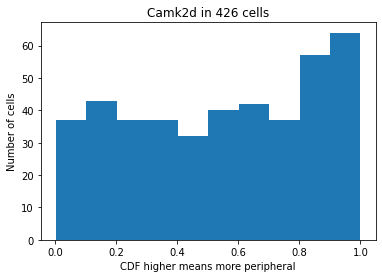

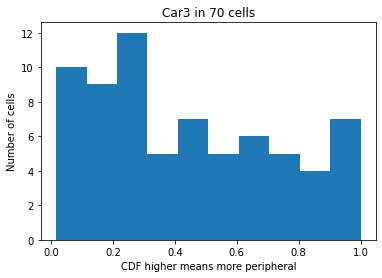

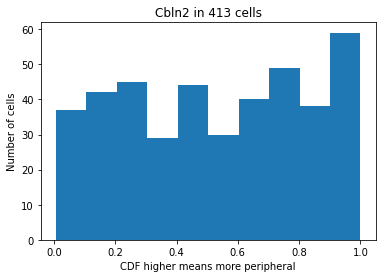

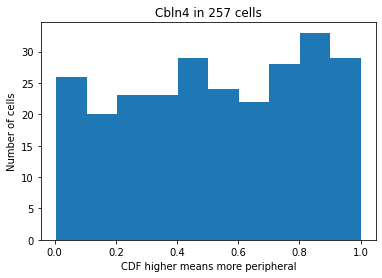

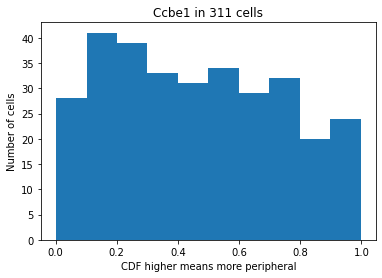

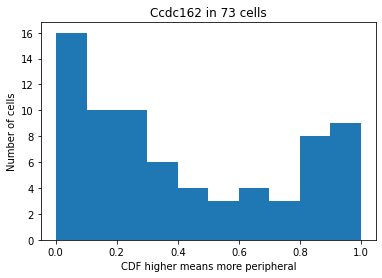

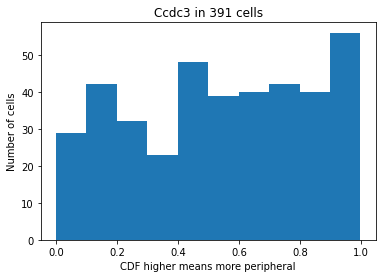

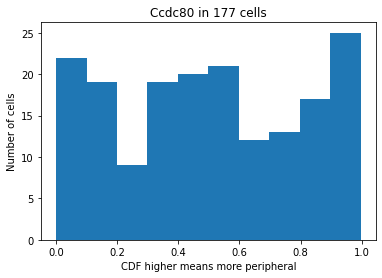

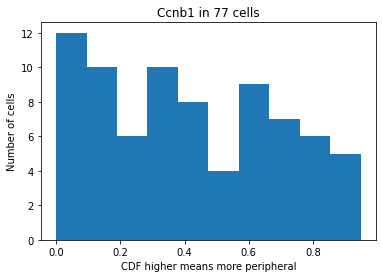

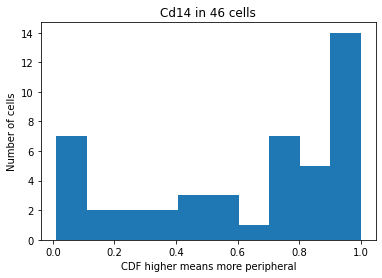

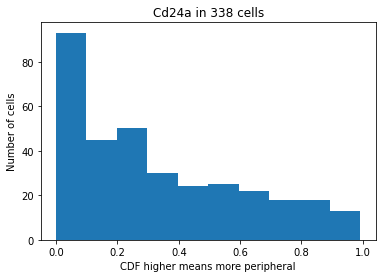

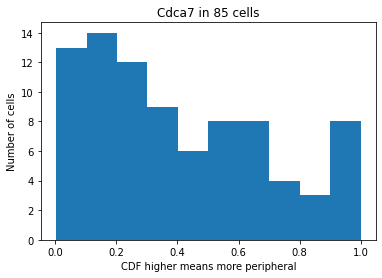

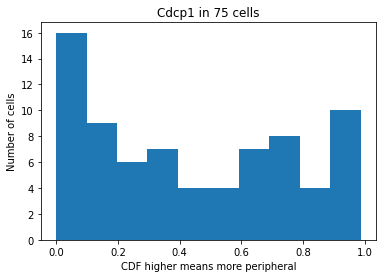

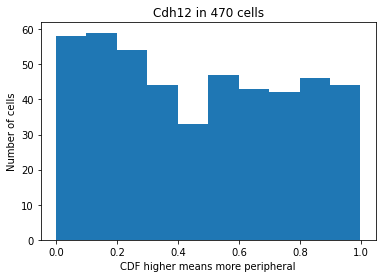

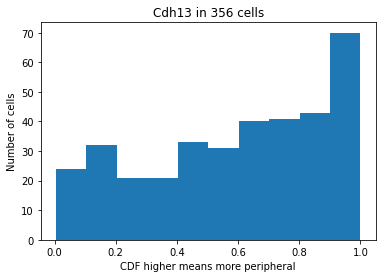

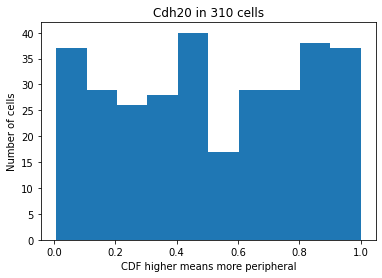

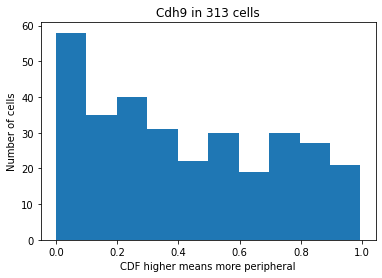

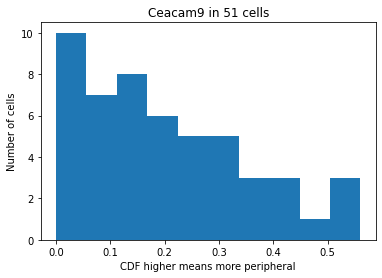

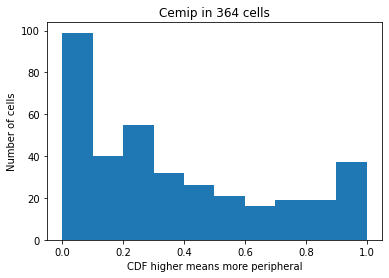

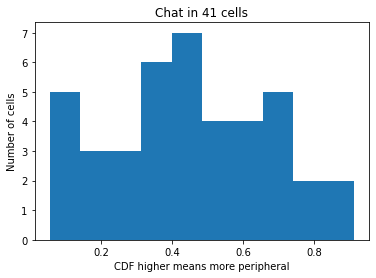

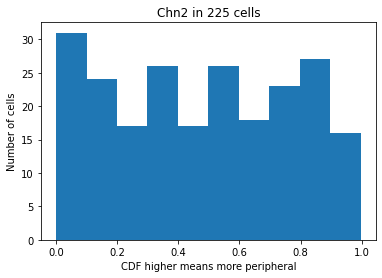

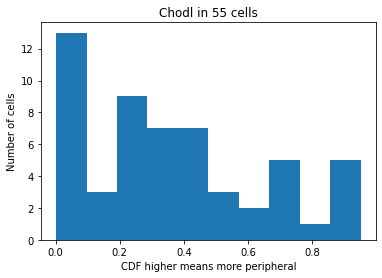

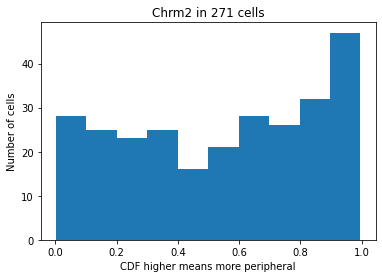

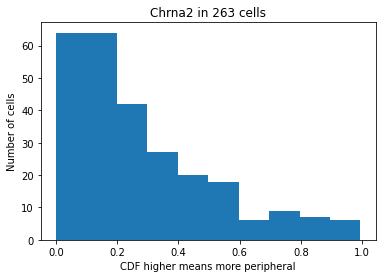

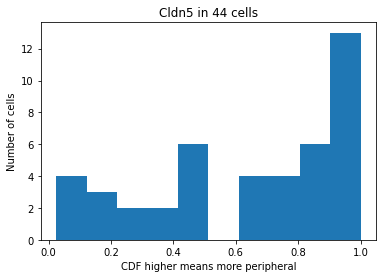

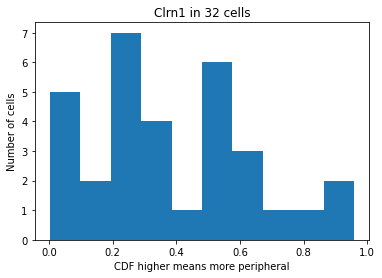

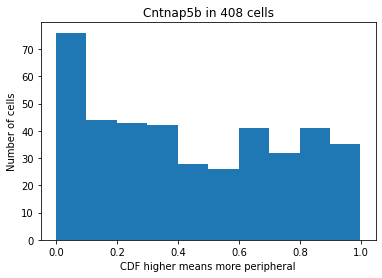

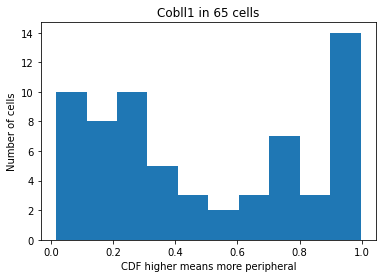

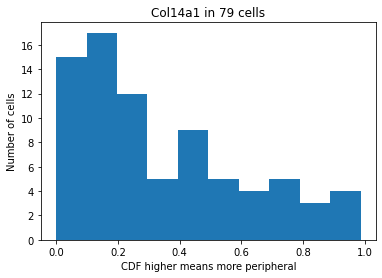

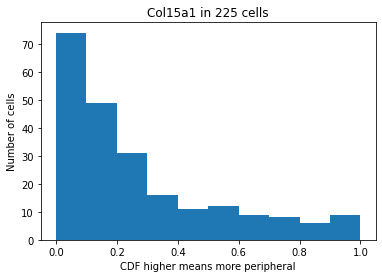

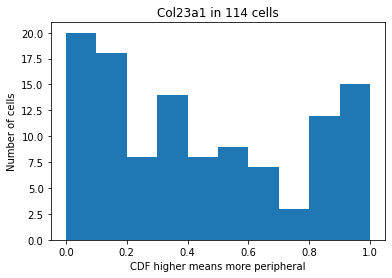

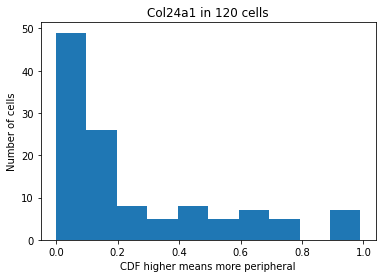

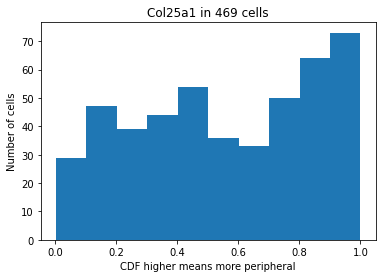

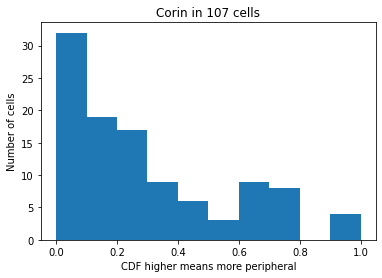

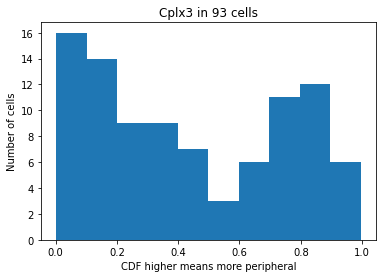

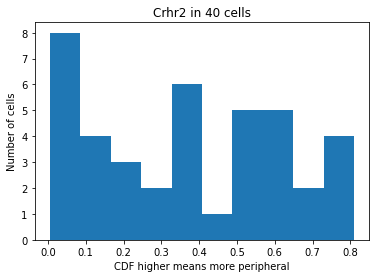

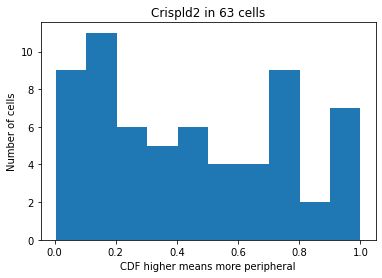

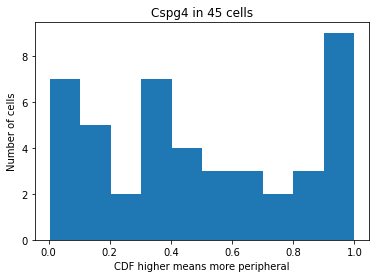

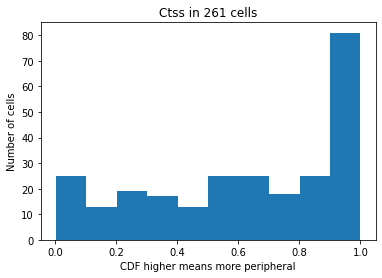

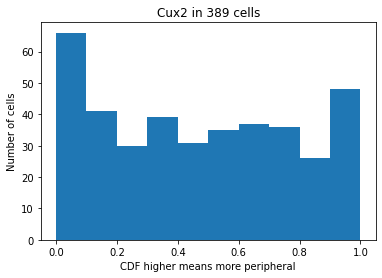

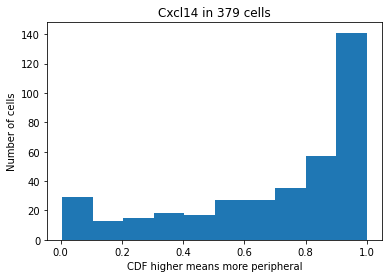

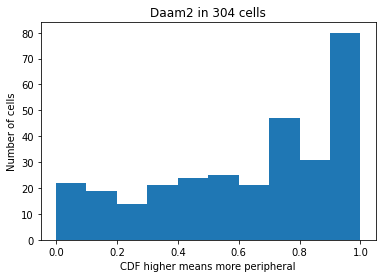

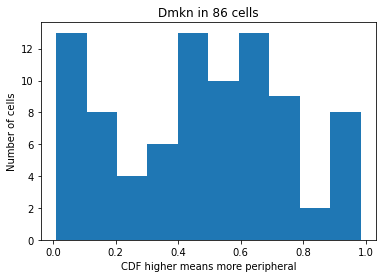

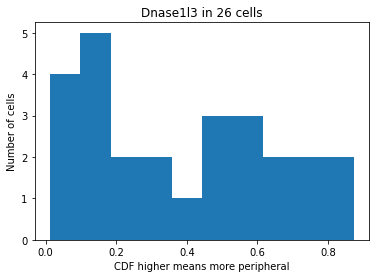

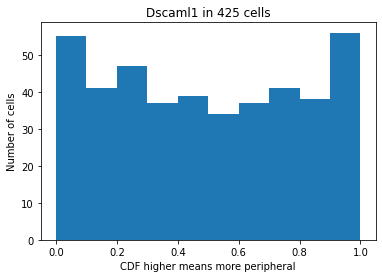

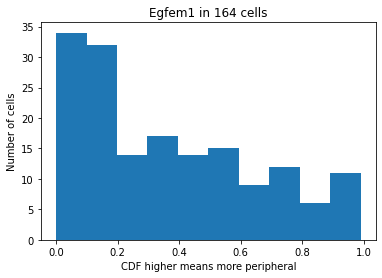

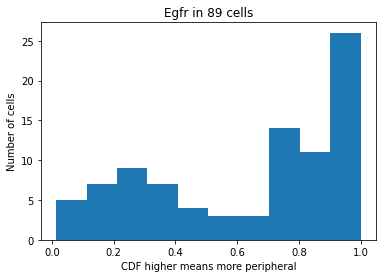

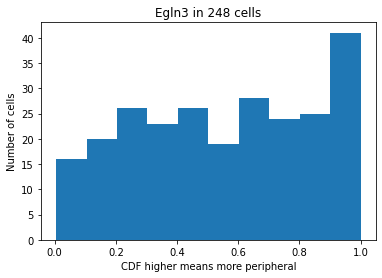

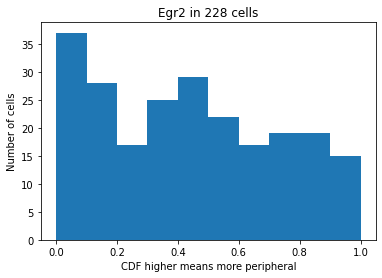

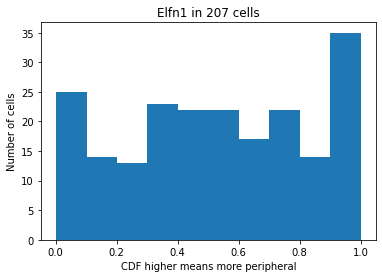

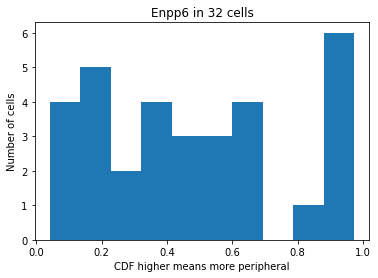

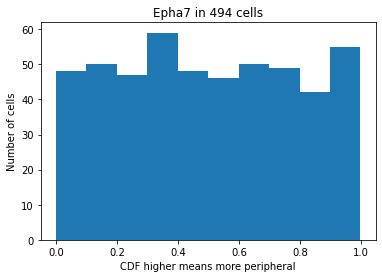

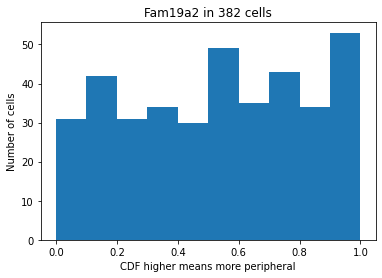

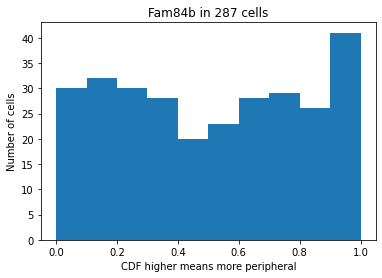

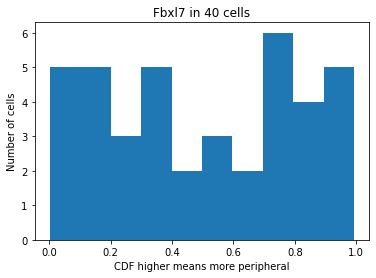

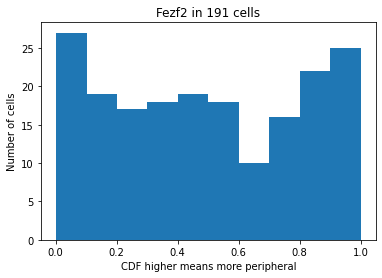

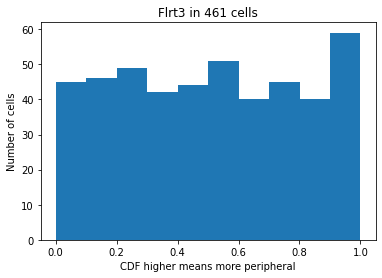

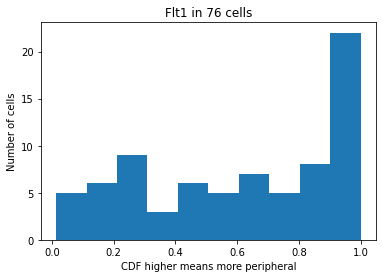

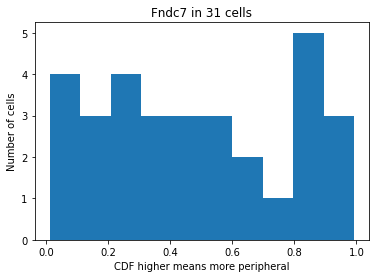

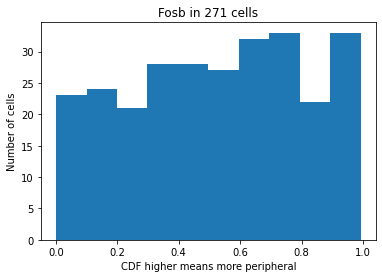

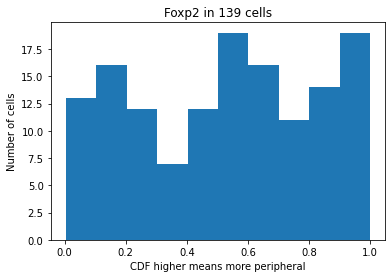

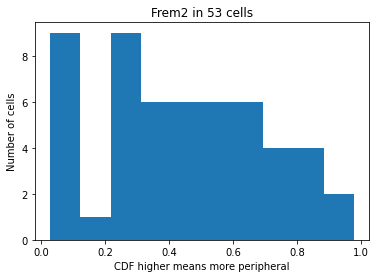

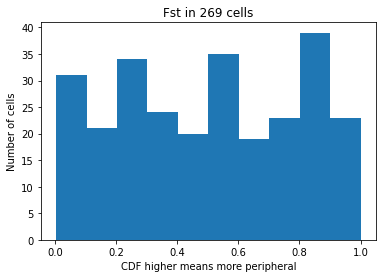

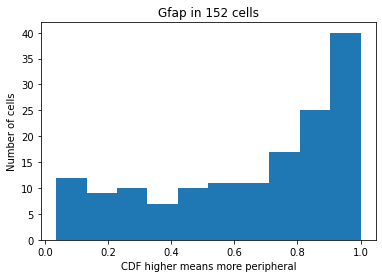

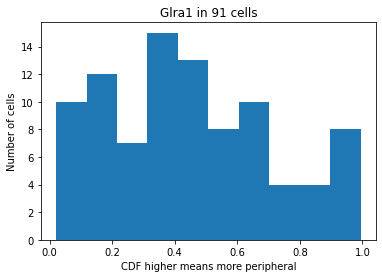

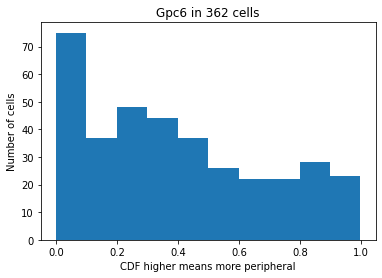

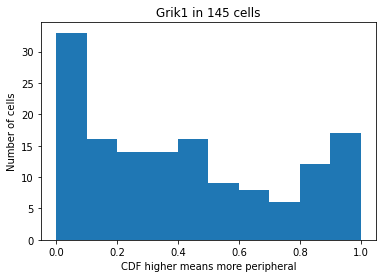

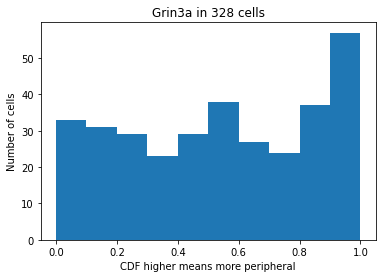

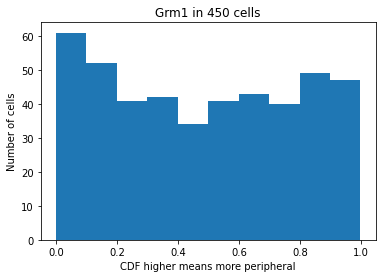

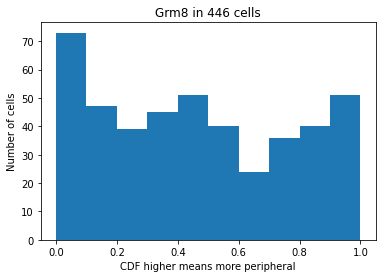

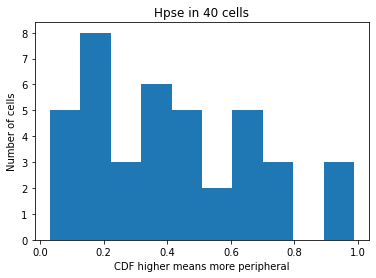

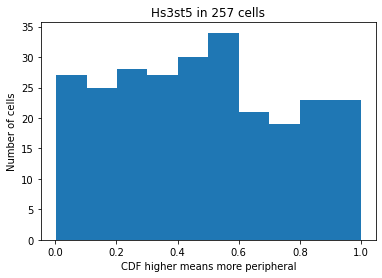

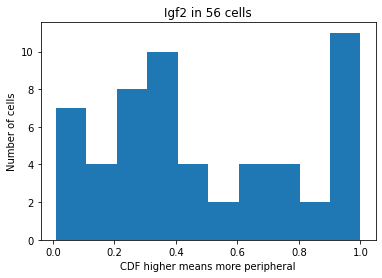

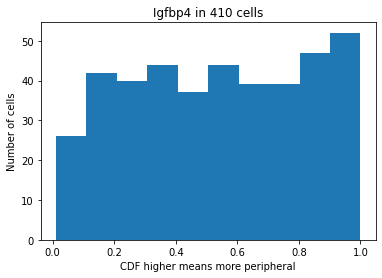

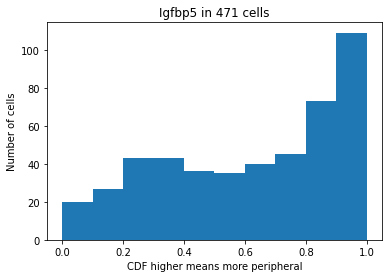

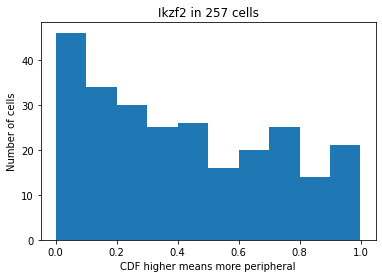

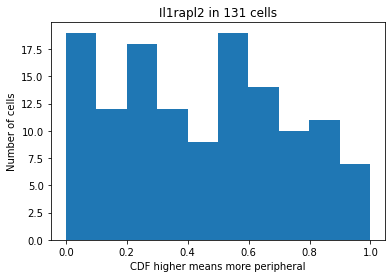

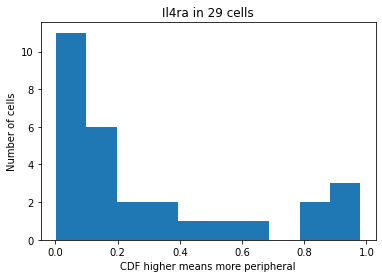

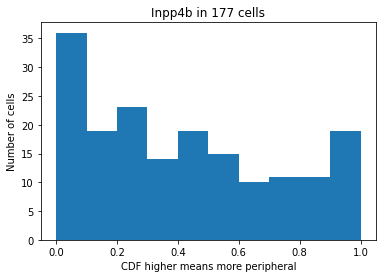

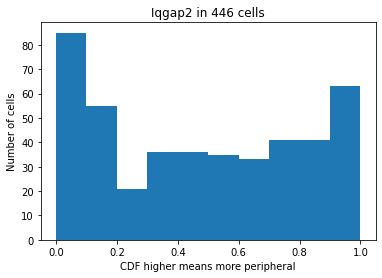

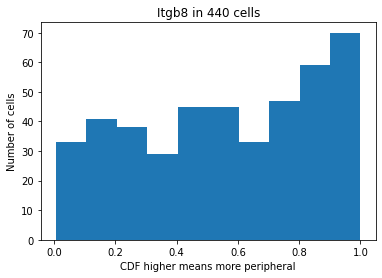

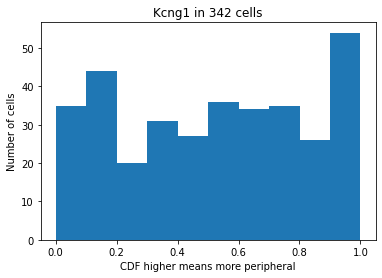

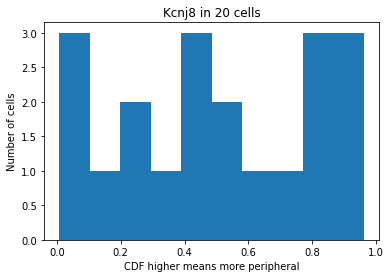

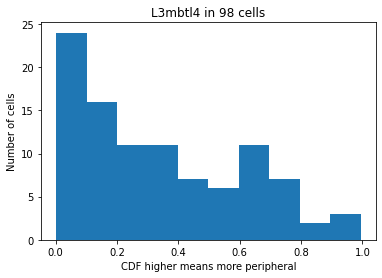

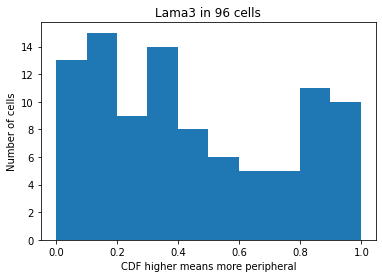

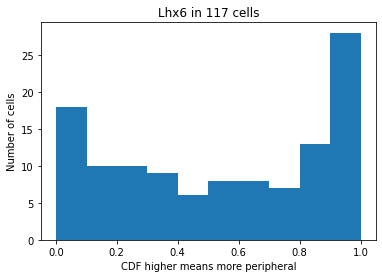

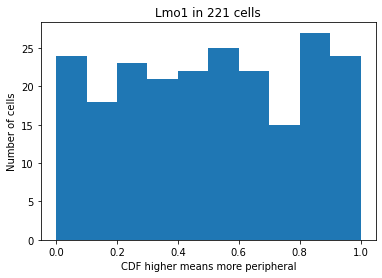

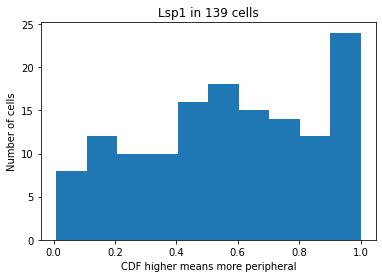

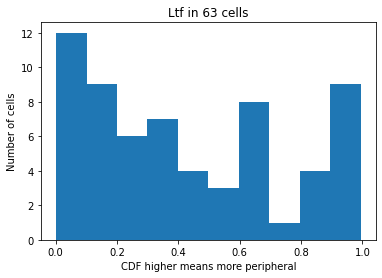

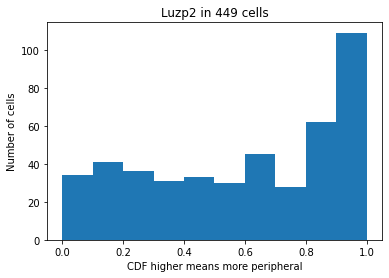

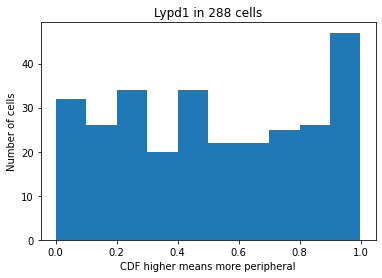

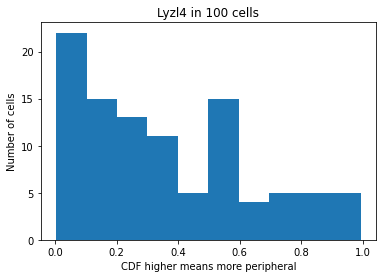

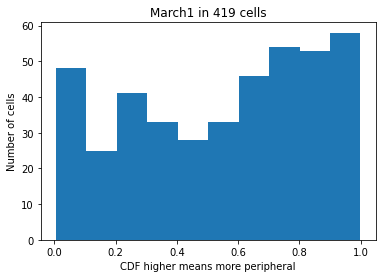

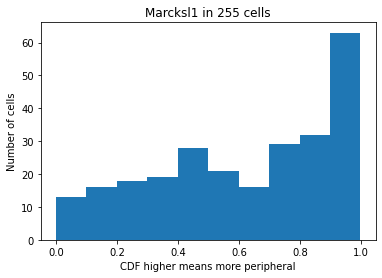

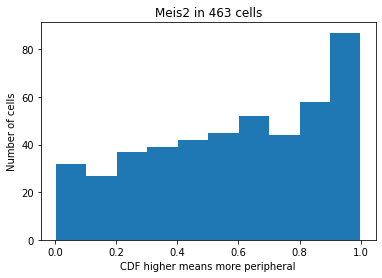

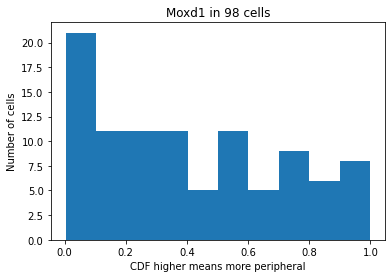

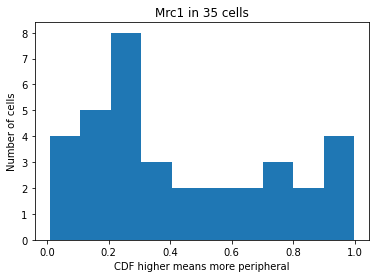

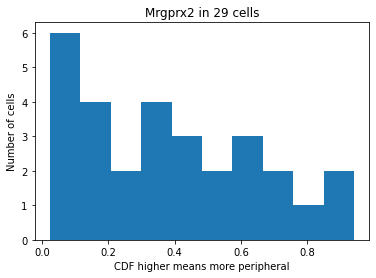

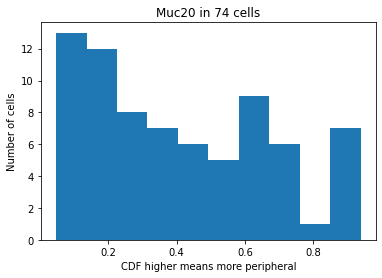

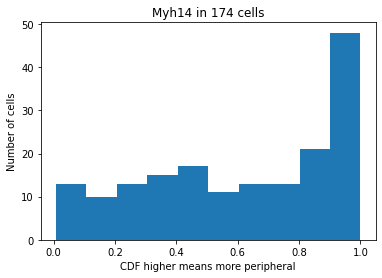

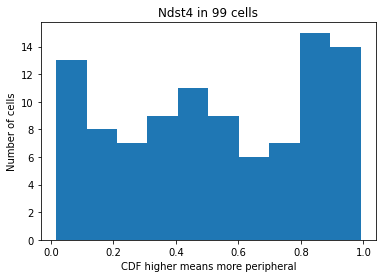

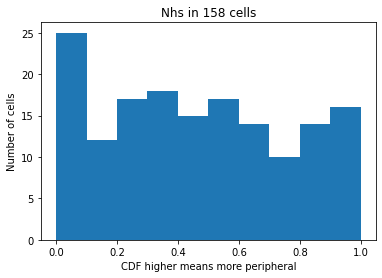

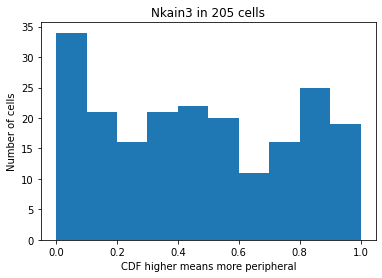

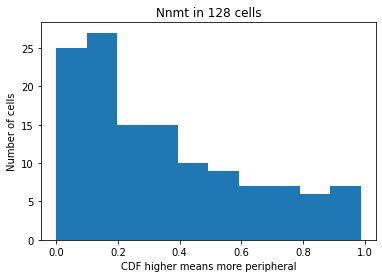

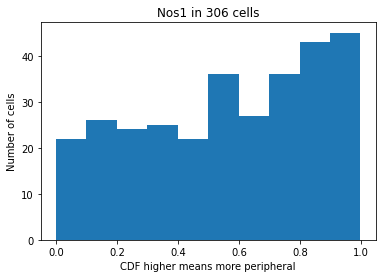

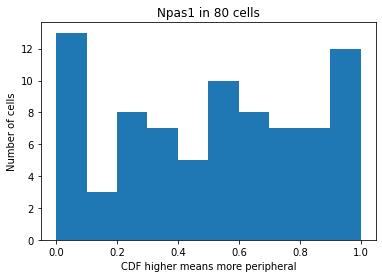

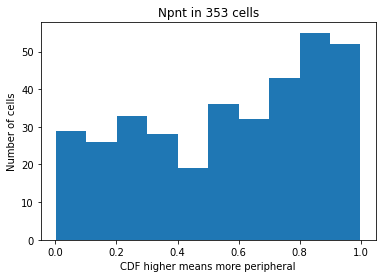

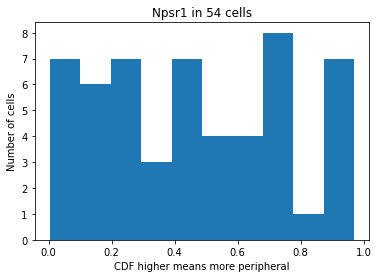

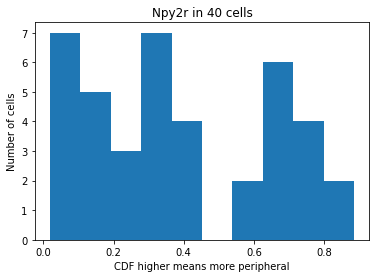

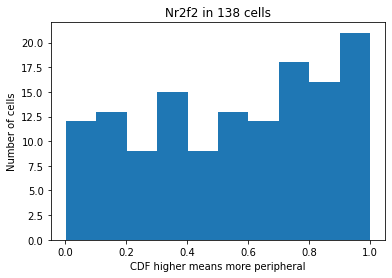

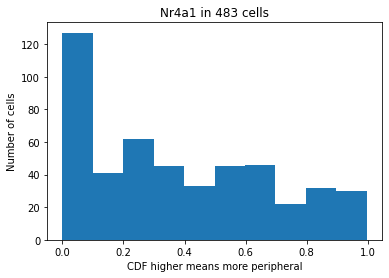

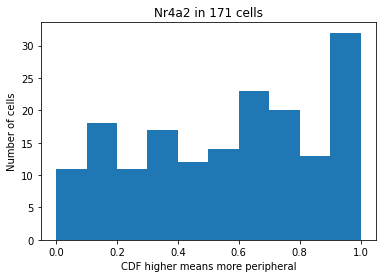

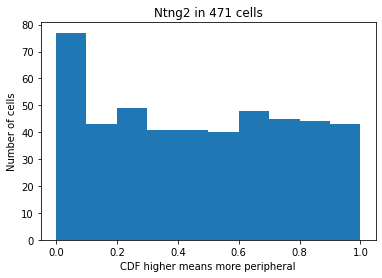

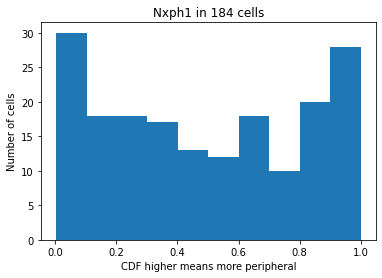

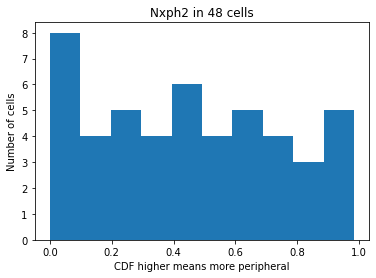

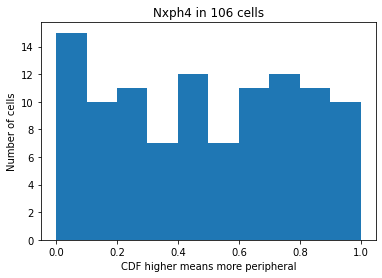

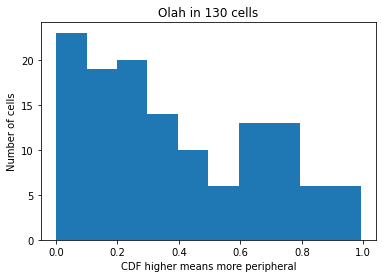

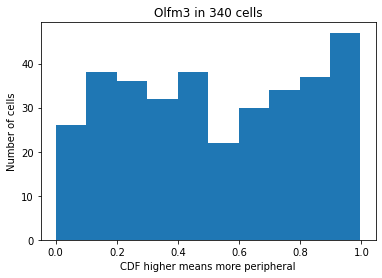

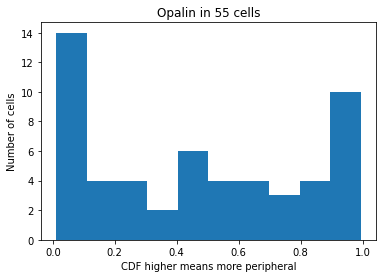

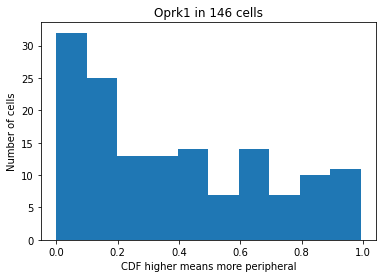

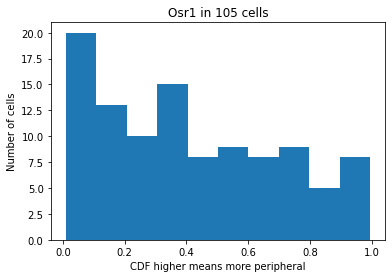

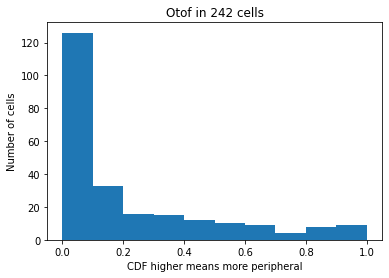

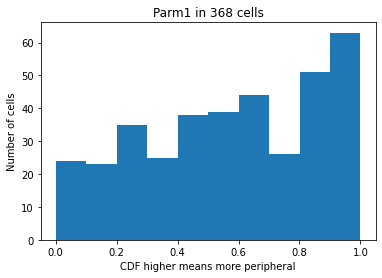

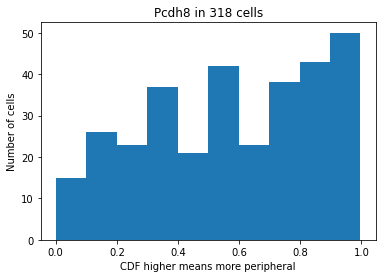

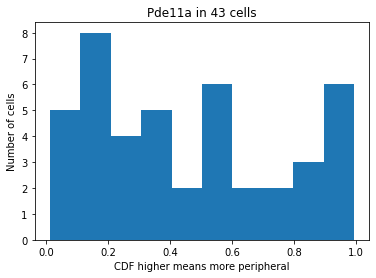

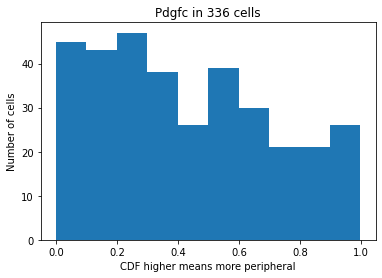

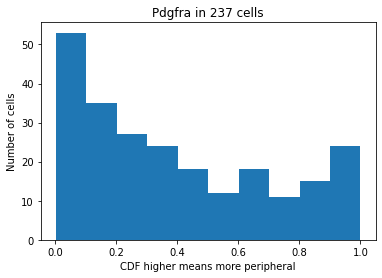

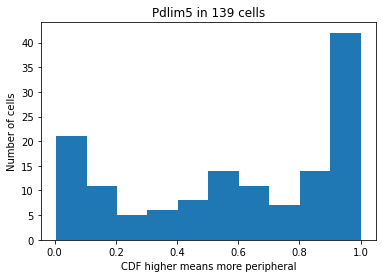

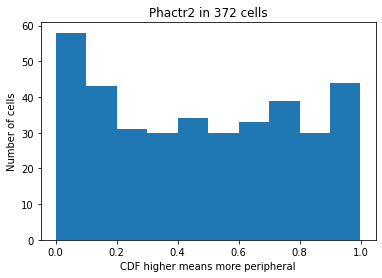

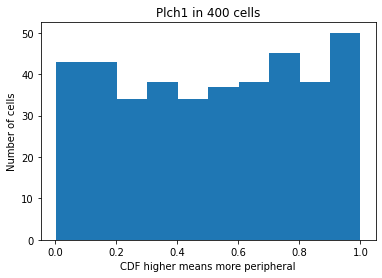

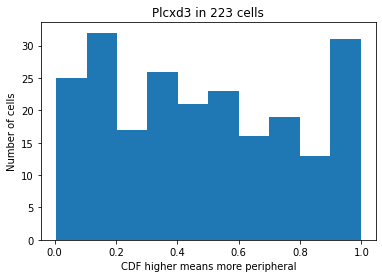

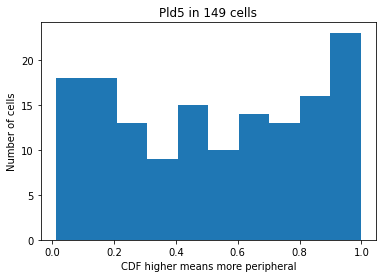

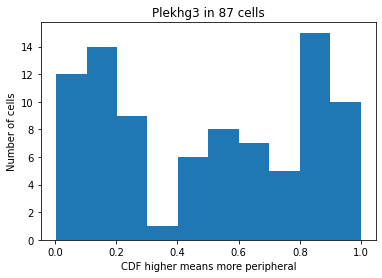

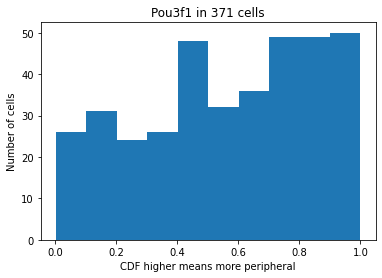

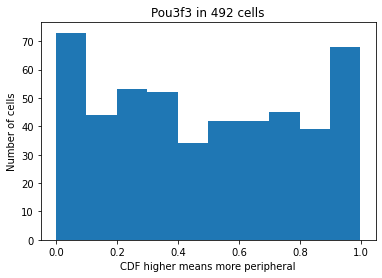

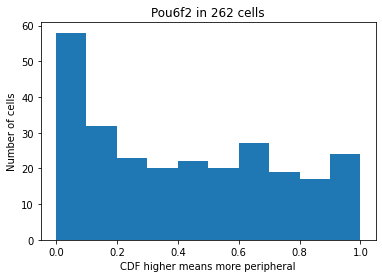

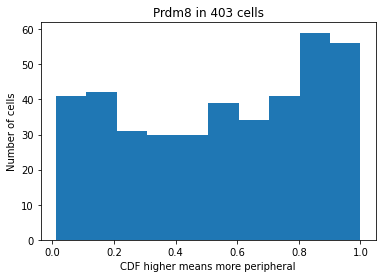

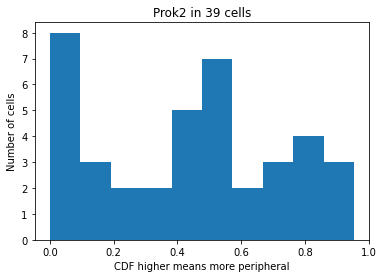

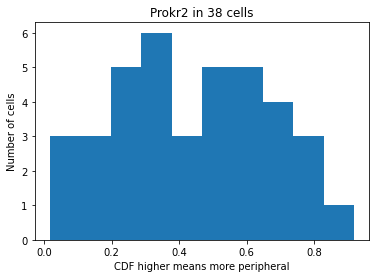

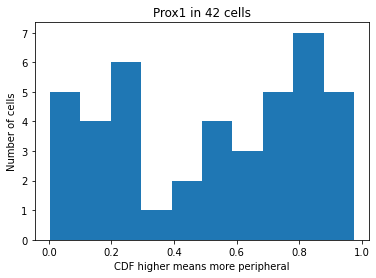

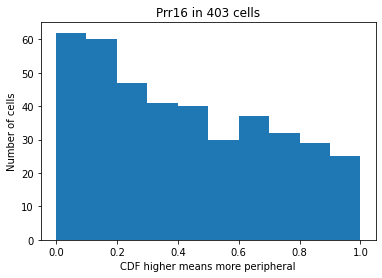

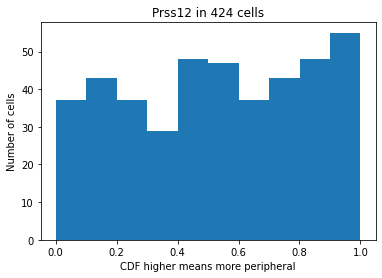

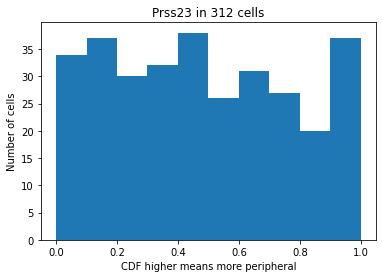

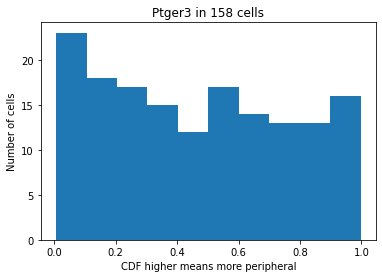

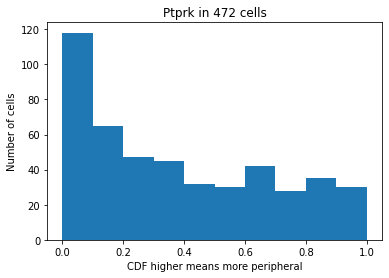

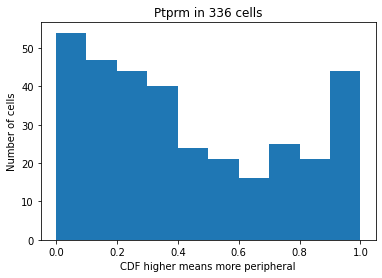

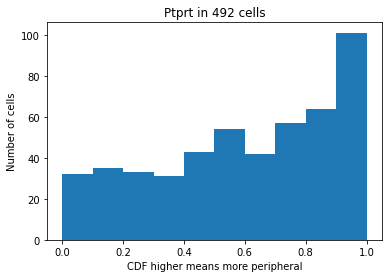

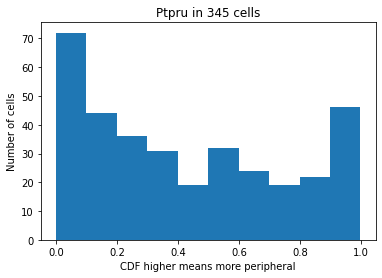

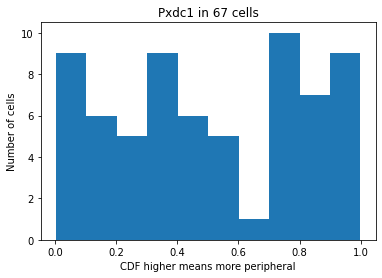

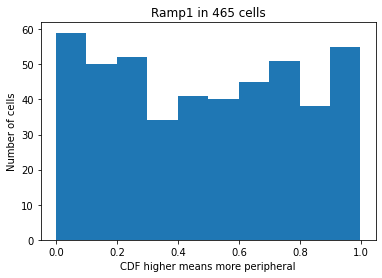

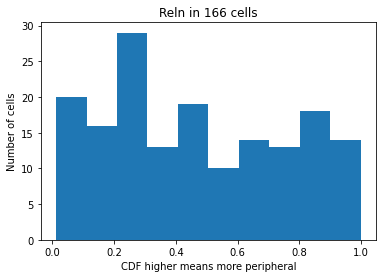

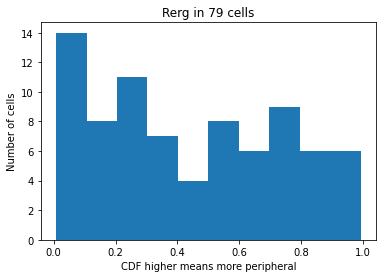

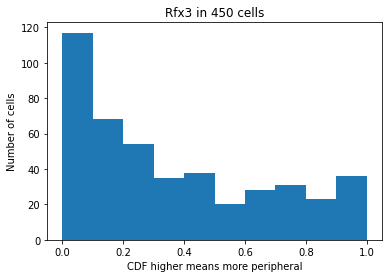

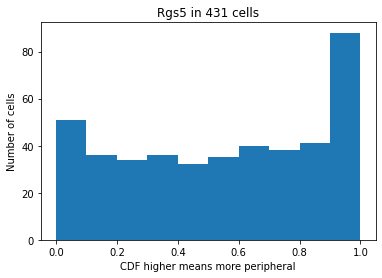

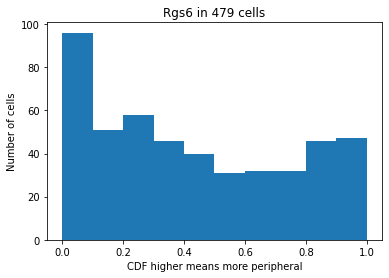

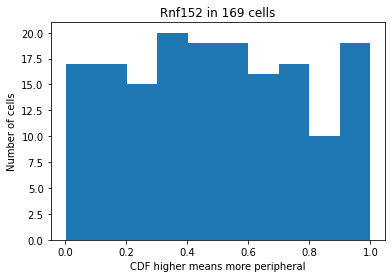

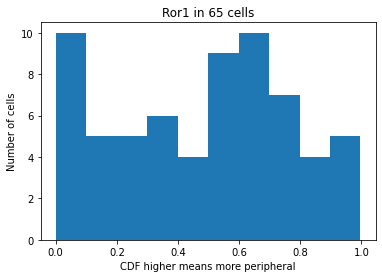

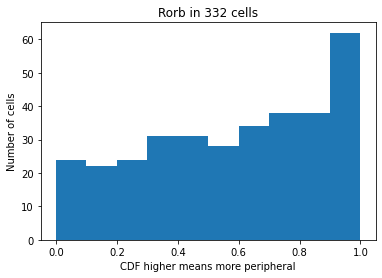

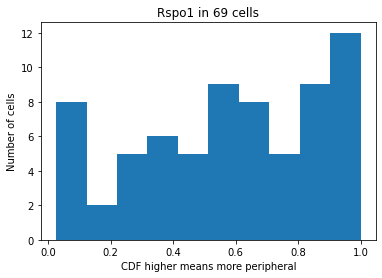

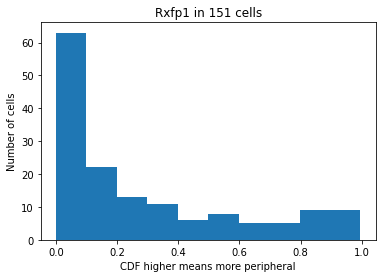

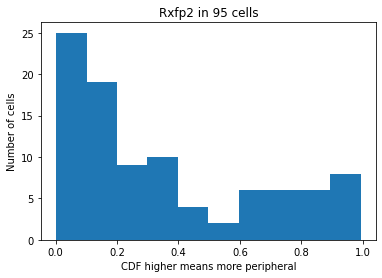

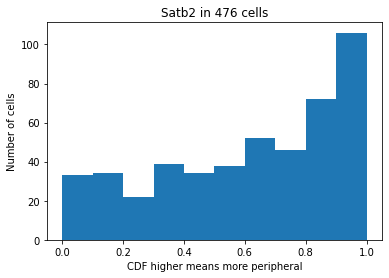

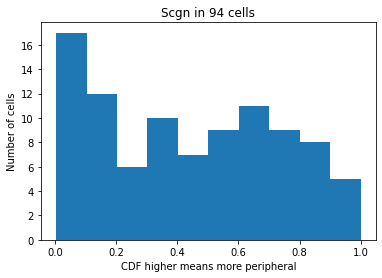

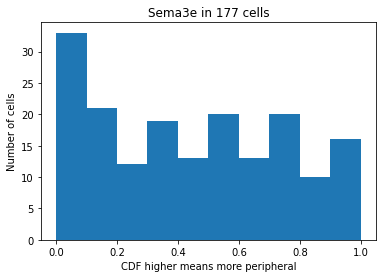

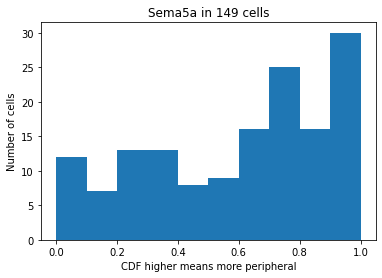

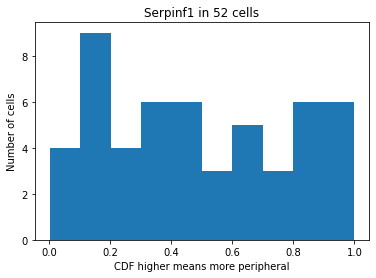

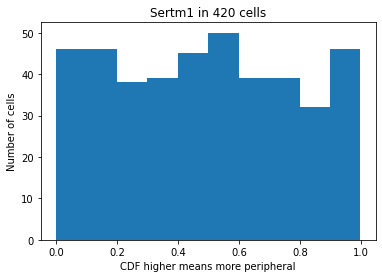

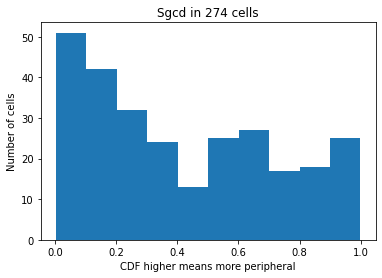

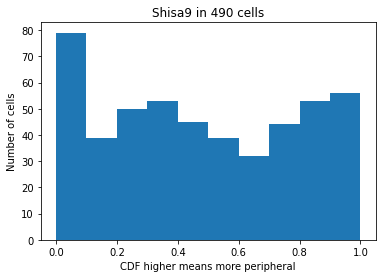

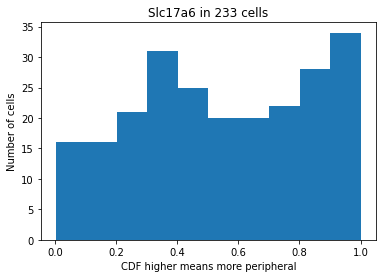

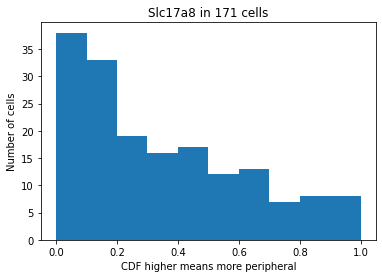

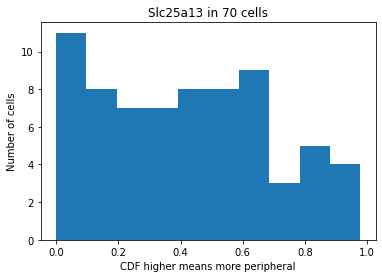

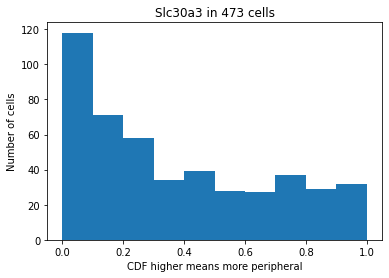

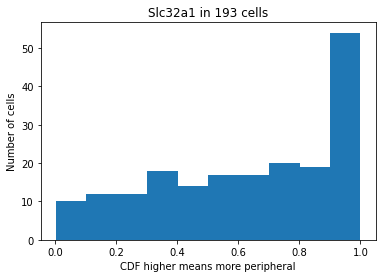

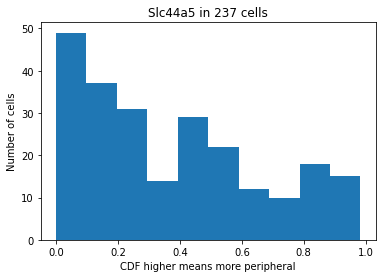

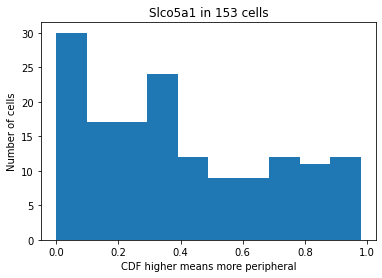

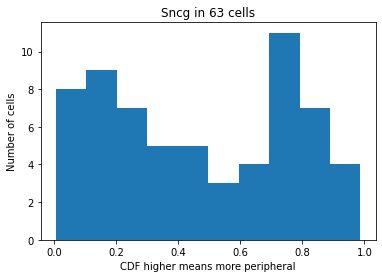

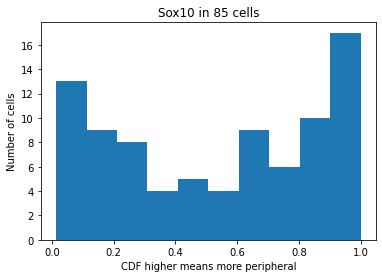

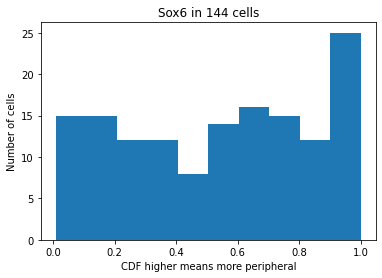

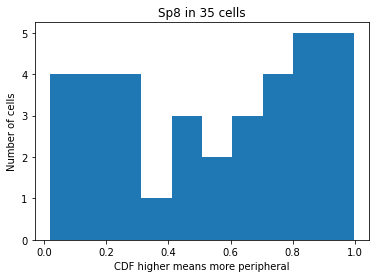

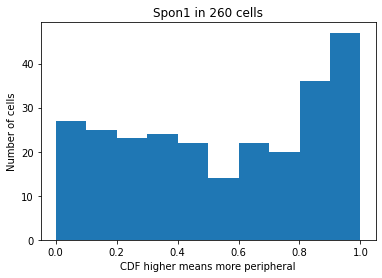

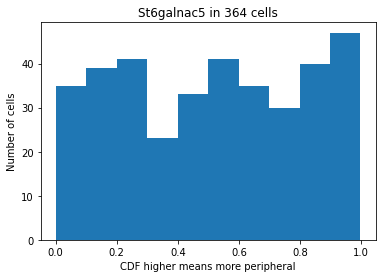

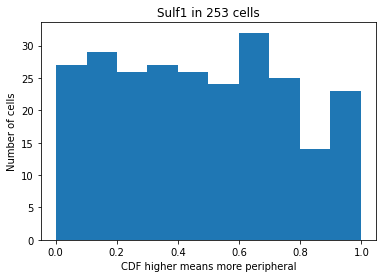

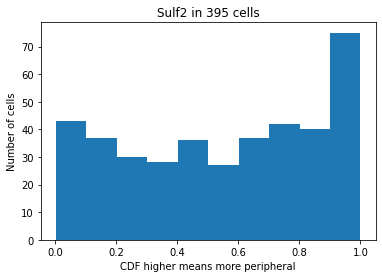

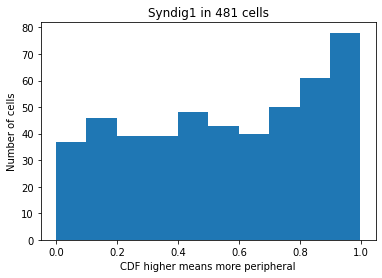

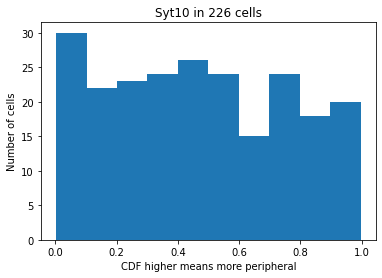

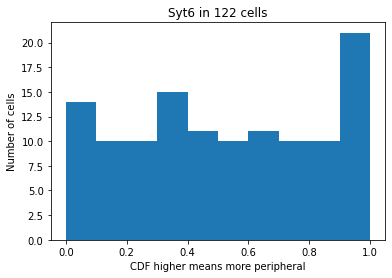

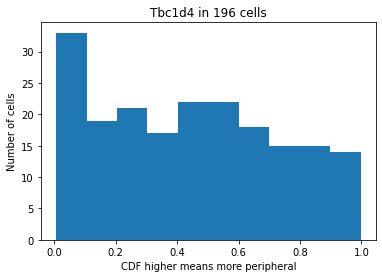

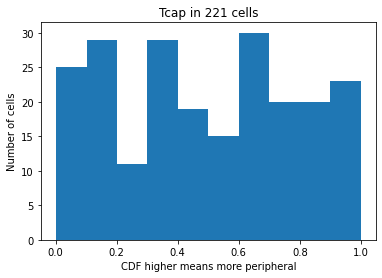

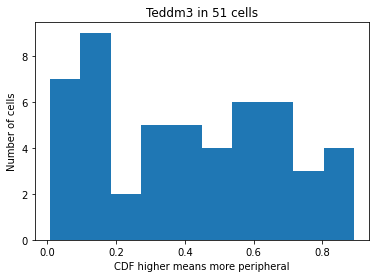

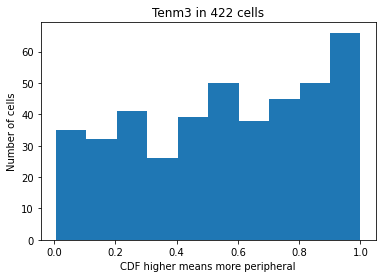

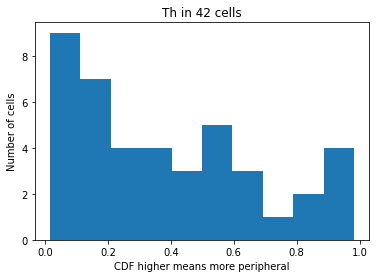

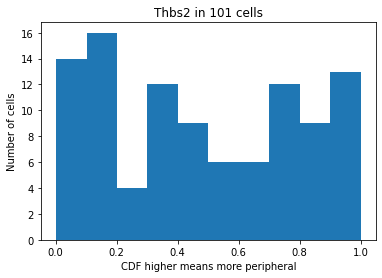

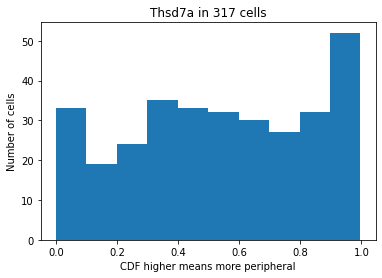

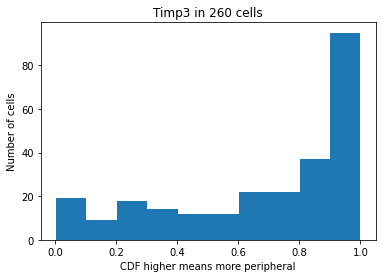

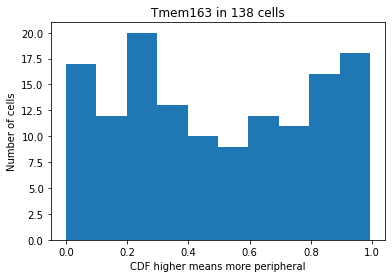

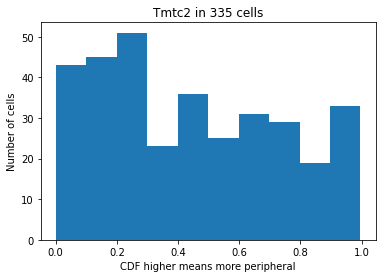

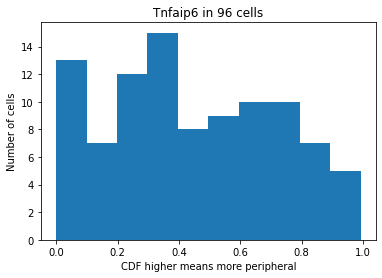

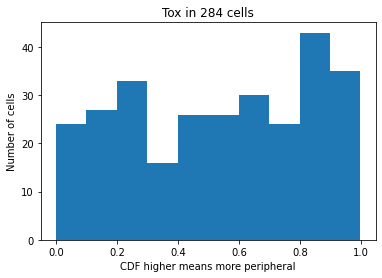

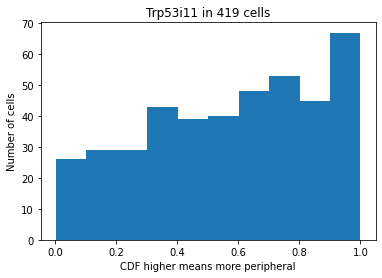

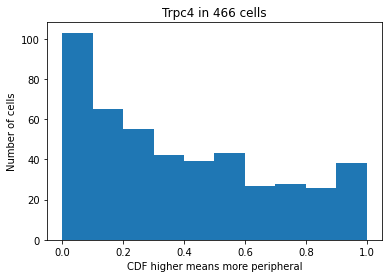

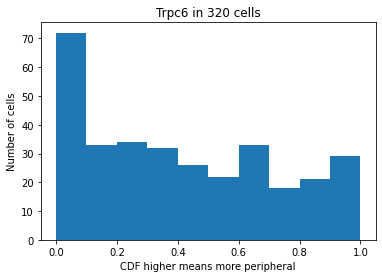

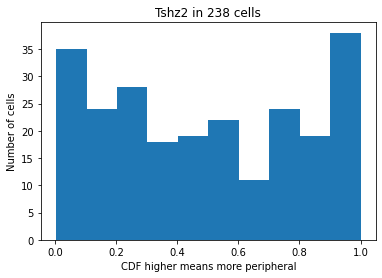

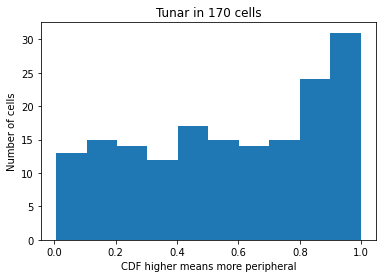

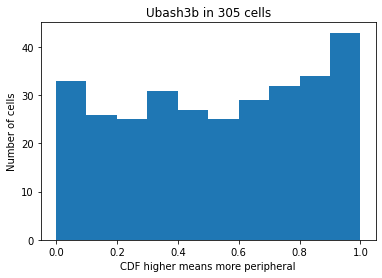

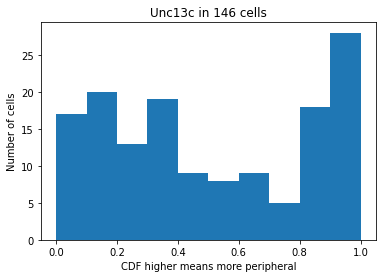

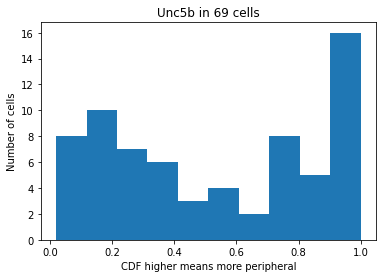

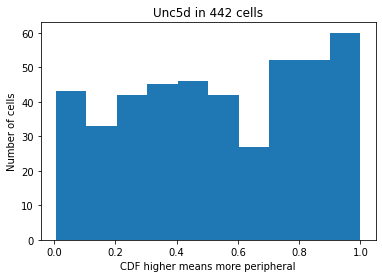

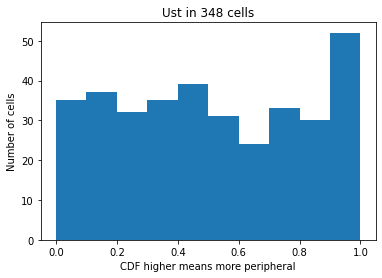

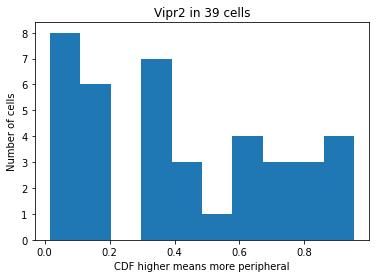

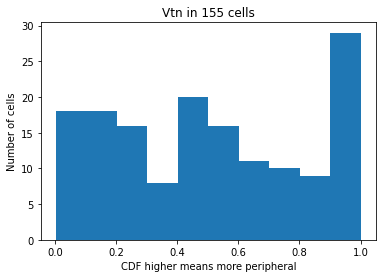

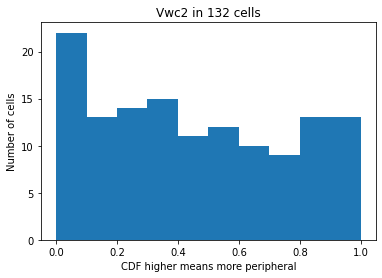

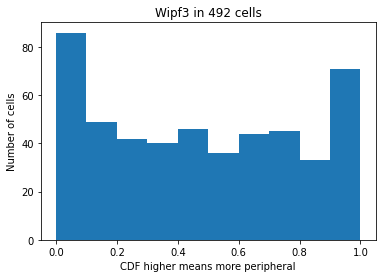

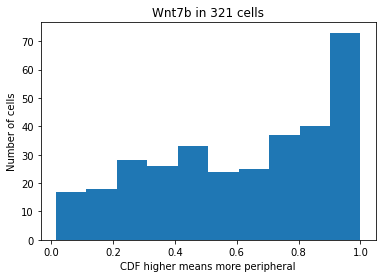

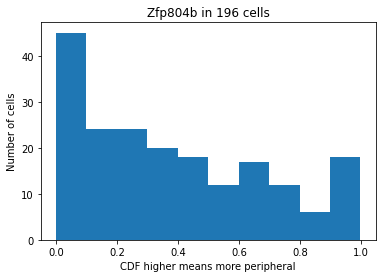

In [262]:
for gene,g in x.groupby(['target_molecule_name']):
    
    g['fraction_perms_larger_than_obs'].plot.hist()
    plt.title('{} in {} cells'.format(gene,g['cell_id'].unique().size))
    plt.xlabel('CDF higher means more peripheral')
    plt.ylabel('Number of cells')
    plt.show()
    plt.close()
    

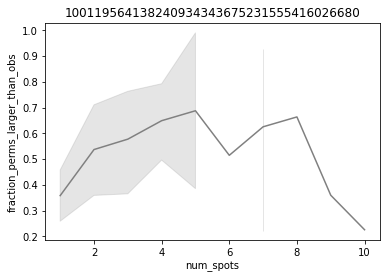

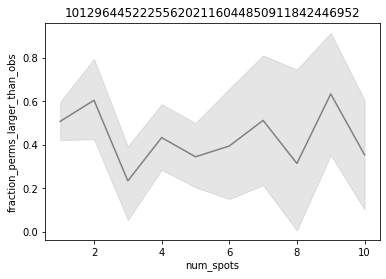

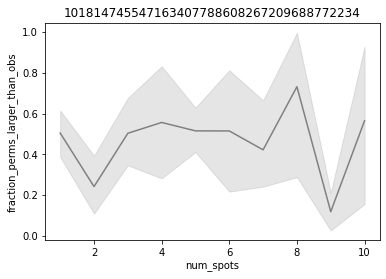

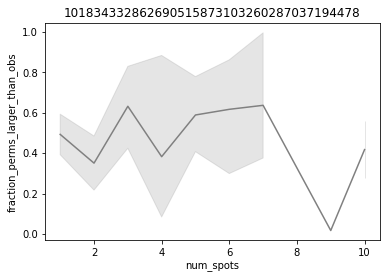

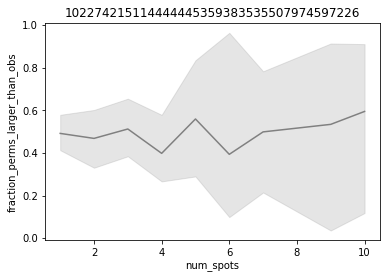

In [275]:
for i,(cell_id,g) in enumerate(x.groupby('cell_id')):
    sns.lineplot(
        x = 'num_spots',
        y = 'fraction_perms_larger_than_obs',
        color = 'grey',
        data = g[g['num_spots'].lt(11)],
    )
    plt.title(cell_id)
    plt.show()
    plt.close()
    
    if i > 3:
        break